# CNN + GlobalAvgPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests RCI GMM(2).

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Rerun CNN_169 with pretty pictures.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-06 12:54:59.101739
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-06 12:55:37.025038
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        self.all_genes = [g for (g,t) in allids]
        
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self, gene_set):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        for i in range(cnt):
            gene_id,tran_id = self.all_ids[i]
            if gene_id in gene_set:
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            # Optimal discriminator = weighted average of means of the 2 gaussians
            discrim = gmm2.weights_[0]*gmm2.means_[0]+gmm2.weights_[1]*gmm2.means_[1]
            print('Model params (mean %.2f, wgt %.2f) (mean %.2f, wgt %.2f)' %
                (gmm2.means_[0], gmm2.weights_[0], gmm2.means_[1], gmm2.weights_[1]))
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(train_index)
            X_train,y_train = self.get_X_y(train_genes)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            valid_genes = self.get_gene_subset(valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            train_genes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-06 12:55:41.566280
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-06 12:56:04.098288
splitting
Fold 1
Model params (mean 0.57, wgt 0.57) (mean -0.93, wgt 0.43)
RCI threshold derived from training set: [-0.06916588]
FIT
2023-02-06 12:56:08.946457
PREDICT
2023-02-06 12:56:29.544547


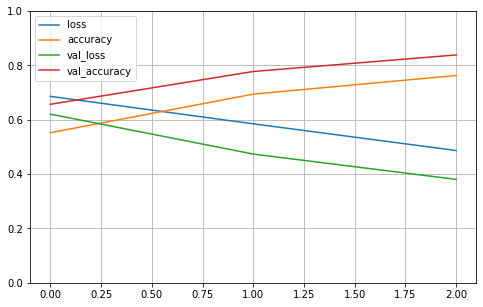

Train set ones/size 4587 / 8534
Compute valiation accuracy
Valid sizes (7302, 4997) (7302,)
Valid set ones/size 4039 / 7302
Range of scores: 0.002053972 to 0.9919464
Score threshold 0.5
Prediction set ones/size 4419 / 7302


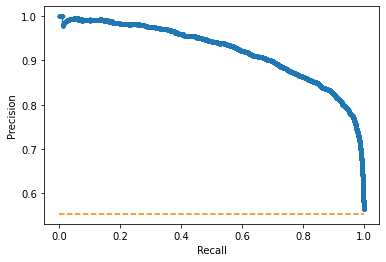

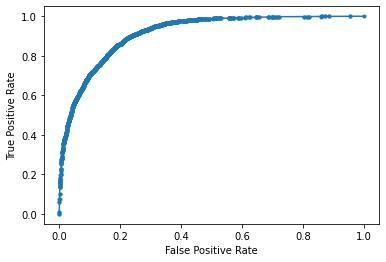

Accuracy: 83.84% Precision: 82.35% Recall: 90.10%
F1: 86.05% AUPRC: 92.24% AUROC: 91.40%
2023-02-06 12:56:31.679851
Fold 2
Model params (mean 0.57, wgt 0.58) (mean -0.93, wgt 0.42)
RCI threshold derived from training set: [-0.06548285]
FIT
2023-02-06 12:56:37.892074
PREDICT
2023-02-06 12:56:51.419176


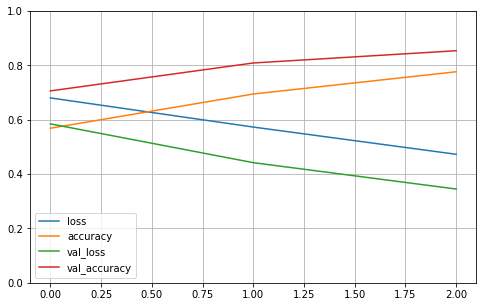

Train set ones/size 4605 / 8543
Compute valiation accuracy
Valid sizes (7341, 4997) (7341,)
Valid set ones/size 4008 / 7341
Range of scores: 0.0019123761 to 0.9994343
Score threshold 0.5
Prediction set ones/size 4535 / 7341


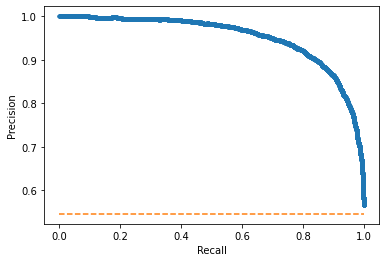

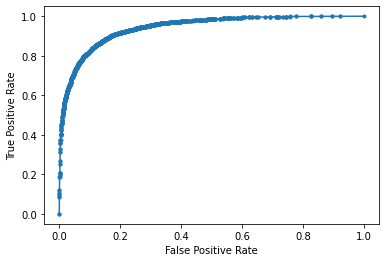

Accuracy: 85.38% Precision: 82.36% Recall: 93.19%
F1: 87.44% AUPRC: 95.18% AUROC: 94.20%
2023-02-06 12:56:54.881135
Fold 3
Model params (mean -0.94, wgt 0.42) (mean 0.57, wgt 0.58)
RCI threshold derived from training set: [-0.06827148]
FIT
2023-02-06 12:57:01.895998
PREDICT
2023-02-06 12:57:23.119212


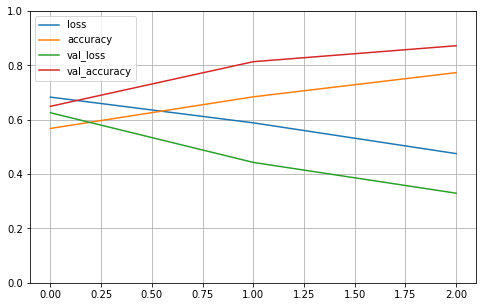

Train set ones/size 4588 / 8522
Compute valiation accuracy
Valid sizes (7318, 4997) (7318,)
Valid set ones/size 4034 / 7318
Range of scores: 0.0027709524 to 0.99752265
Score threshold 0.5
Prediction set ones/size 4017 / 7318


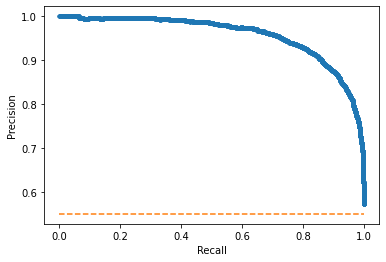

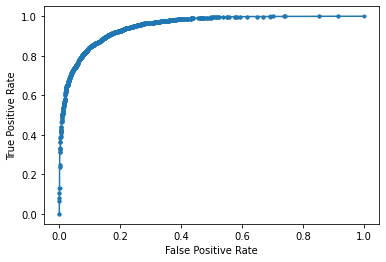

Accuracy: 87.22% Precision: 88.57% Recall: 88.20%
F1: 88.39% AUPRC: 95.77% AUROC: 94.97%
2023-02-06 12:57:24.628132
Fold 4
Model params (mean -0.93, wgt 0.43) (mean 0.57, wgt 0.57)
RCI threshold derived from training set: [-0.06762457]
FIT
2023-02-06 12:57:30.945639
PREDICT
2023-02-06 12:57:52.606553


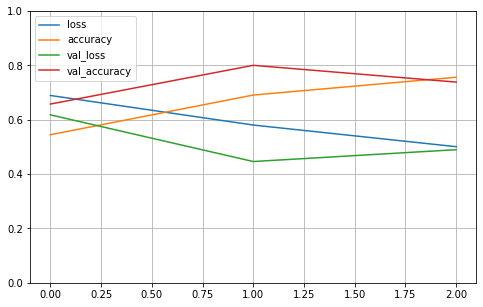

Train set ones/size 4590 / 8538
Compute valiation accuracy
Valid sizes (7240, 4997) (7240,)
Valid set ones/size 3936 / 7240
Range of scores: 0.0052793096 to 0.99797195
Score threshold 0.5
Prediction set ones/size 5734 / 7240


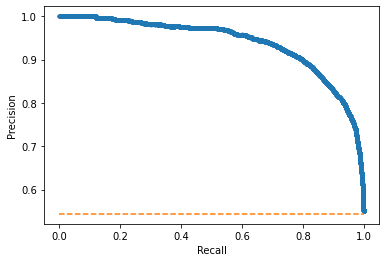

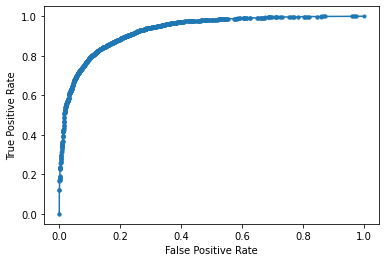

Accuracy: 73.84% Precision: 67.81% Recall: 98.78%
F1: 80.41% AUPRC: 93.92% AUROC: 92.93%
2023-02-06 12:57:54.242644
Fold 5
Model params (mean 0.57, wgt 0.57) (mean -0.92, wgt 0.43)
RCI threshold derived from training set: [-0.06622309]
FIT
2023-02-06 12:58:02.483549
PREDICT
2023-02-06 12:58:23.889513


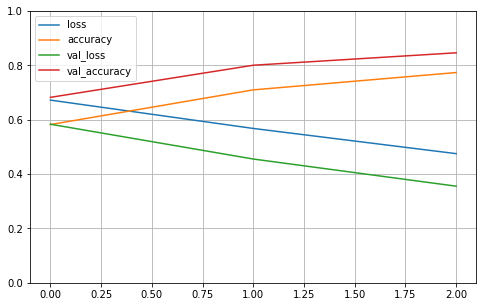

Train set ones/size 4597 / 8546
Compute valiation accuracy
Valid sizes (7302, 4997) (7302,)
Valid set ones/size 3998 / 7302
Range of scores: 0.004296888 to 0.99820423
Score threshold 0.5
Prediction set ones/size 4753 / 7302


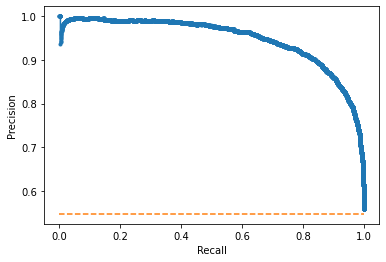

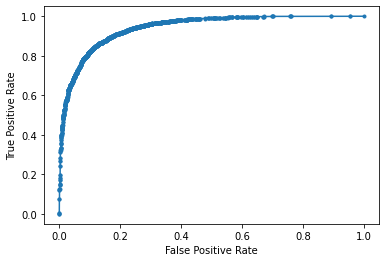

Accuracy: 84.62% Precision: 80.24% Recall: 95.40%
F1: 87.17% AUPRC: 94.86% AUROC: 94.18%
2023-02-06 12:58:25.788380

Completed cross validation 5 folds 3 epochs
 accuracy mean 82.98% +/- 4.71
 precision mean 80.27% +/- 6.83
 recall mean 93.13% +/- 3.76
 F1 mean 85.89% +/- 2.84
 AUPRC mean 94.39% +/- 1.23
 AUROC mean 93.54% +/- 1.25
Finished cell Line 0 A549

2023-02-06 12:58:27.314991
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-06 12:58:54.833208
splitting
Fold 1
Model params (mean -0.92, wgt 0.53) (mean 0.44, wgt 0.47)
RCI threshold derived from training set: [-0.27661057]
FIT
2023-02-06 12:59:03.897885
PREDICT
2023-02-06 12:59:46.088016


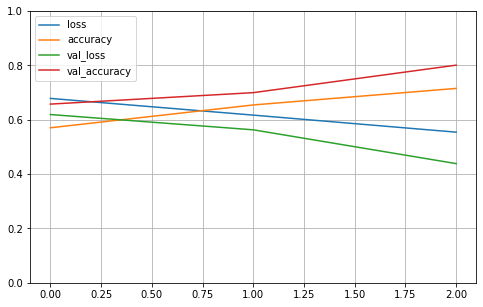

Train set ones/size 8084 / 16148
Compute valiation accuracy
Valid sizes (13318, 4997) (13318,)
Valid set ones/size 6576 / 13318
Range of scores: 0.0016765536 to 0.9954572
Score threshold 0.5
Prediction set ones/size 5631 / 13318


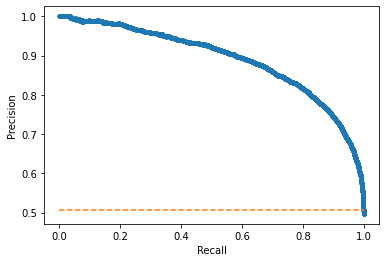

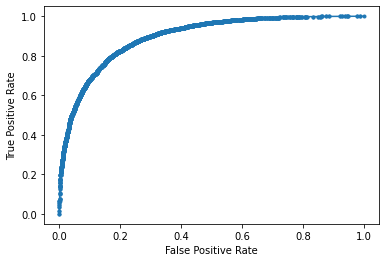

Accuracy: 80.08% Precision: 84.83% Recall: 72.64%
F1: 78.27% AUPRC: 89.06% AUROC: 89.56%
2023-02-06 12:59:48.784728
Fold 2
Model params (mean 0.44, wgt 0.47) (mean -0.92, wgt 0.53)
RCI threshold derived from training set: [-0.28098791]
FIT
2023-02-06 13:00:00.126290
PREDICT
2023-02-06 13:00:21.171545


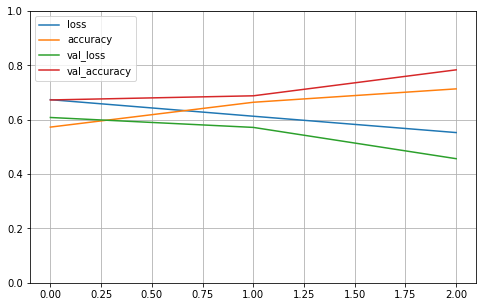

Train set ones/size 8055 / 16141
Compute valiation accuracy
Valid sizes (13266, 4997) (13266,)
Valid set ones/size 6625 / 13266
Range of scores: 0.0059990105 to 0.99729496
Score threshold 0.5
Prediction set ones/size 4907 / 13266


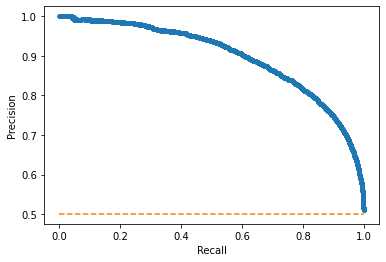

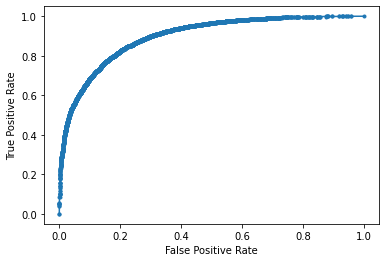

Accuracy: 78.35% Precision: 88.24% Recall: 65.36%
F1: 75.10% AUPRC: 89.80% AUROC: 89.72%
2023-02-06 13:00:24.622145
Fold 3
Model params (mean 0.44, wgt 0.47) (mean -0.92, wgt 0.53)
RCI threshold derived from training set: [-0.28319813]
FIT
2023-02-06 13:00:35.488503
PREDICT
2023-02-06 13:00:56.328757


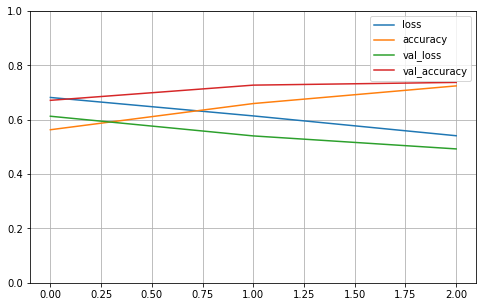

Train set ones/size 8044 / 16135
Compute valiation accuracy
Valid sizes (13357, 4997) (13357,)
Valid set ones/size 6708 / 13357
Range of scores: 0.0038665398 to 0.991054
Score threshold 0.5
Prediction set ones/size 3729 / 13357


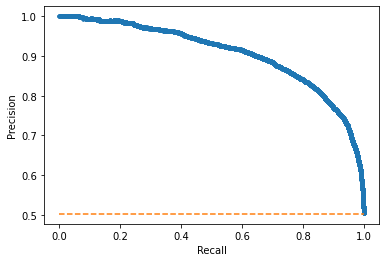

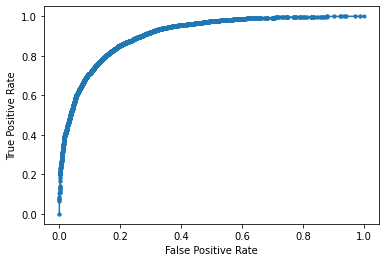

Accuracy: 73.73% Precision: 92.89% Recall: 51.64%
F1: 66.38% AUPRC: 90.67% AUROC: 90.79%
2023-02-06 13:00:59.881238
Fold 4
Model params (mean -0.92, wgt 0.53) (mean 0.44, wgt 0.47)
RCI threshold derived from training set: [-0.2769019]
FIT
2023-02-06 13:01:11.580513
PREDICT
2023-02-06 13:01:32.948910


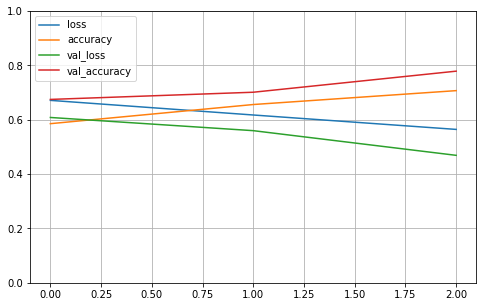

Train set ones/size 8096 / 16167
Compute valiation accuracy
Valid sizes (13160, 4997) (13160,)
Valid set ones/size 6521 / 13160
Range of scores: 0.00085899426 to 0.9985065
Score threshold 0.5
Prediction set ones/size 5394 / 13160


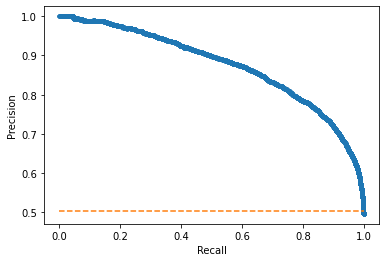

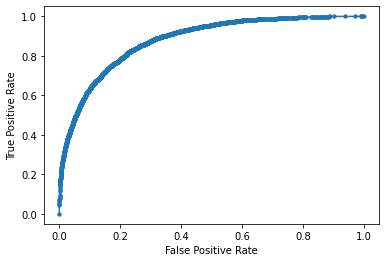

Accuracy: 77.86% Precision: 83.44% Recall: 69.02%
F1: 75.55% AUPRC: 87.51% AUROC: 87.83%
2023-02-06 13:01:35.412189
Fold 5
Model params (mean 0.56, wgt 0.40) (mean -0.84, wgt 0.60)
RCI threshold derived from training set: [-0.27796975]
FIT
2023-02-06 13:01:45.535450
PREDICT
2023-02-06 13:02:06.923332


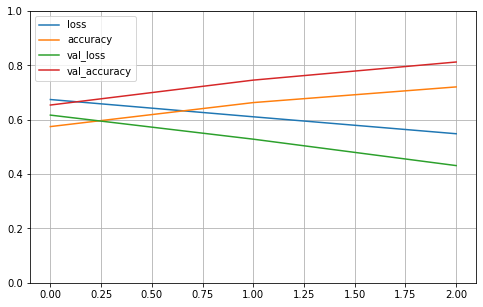

Train set ones/size 8073 / 16145
Compute valiation accuracy
Valid sizes (13206, 4997) (13206,)
Valid set ones/size 6514 / 13206
Range of scores: 0.0068487767 to 0.99688256
Score threshold 0.5
Prediction set ones/size 6248 / 13206


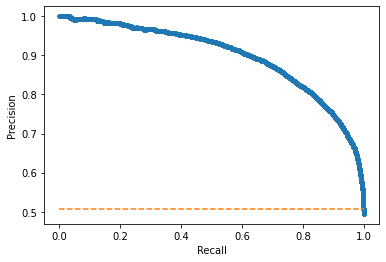

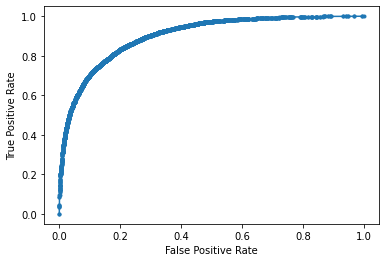

Accuracy: 81.24% Precision: 82.30% Recall: 78.94%
F1: 80.58% AUPRC: 89.83% AUROC: 90.15%
2023-02-06 13:02:09.140453

Completed cross validation 5 folds 3 epochs
 accuracy mean 78.25% +/- 2.56
 precision mean 86.34% +/- 3.84
 recall mean 67.52% +/- 9.12
 F1 mean 75.18% +/- 4.82
 AUPRC mean 89.38% +/- 1.06
 AUROC mean 89.61% +/- 0.99
Finished cell Line 1 H1.hESC

2023-02-06 13:02:10.700749
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-06 13:02:21.225871
splitting
Fold 1
Model params (mean -2.21, wgt 0.62) (mean 0.24, wgt 0.38)
RCI threshold derived from training set: [-1.28076592]
FIT
2023-02-06 13:02:25.154525
PREDICT
2023-02-06 13:02:34.607393


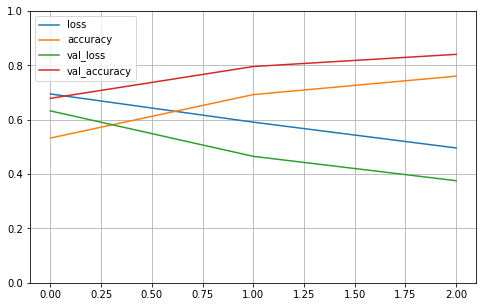

Train set ones/size 2768 / 5731
Compute valiation accuracy
Valid sizes (5004, 4997) (5004,)
Valid set ones/size 2419 / 5004
Range of scores: 0.0012656293 to 0.9935063
Score threshold 0.5
Prediction set ones/size 2461 / 5004


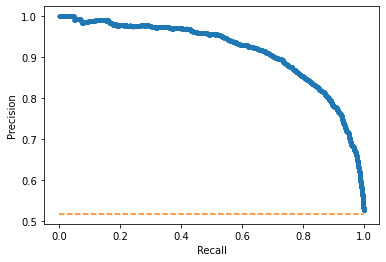

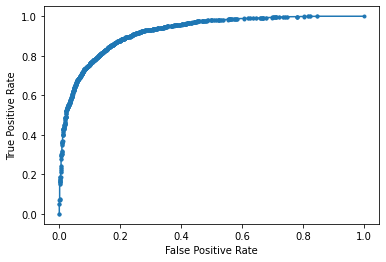

Accuracy: 84.05% Precision: 82.93% Recall: 84.37%
F1: 83.65% AUPRC: 91.59% AUROC: 92.14%
2023-02-06 13:02:35.946858
Fold 2
Model params (mean -2.21, wgt 0.62) (mean 0.25, wgt 0.38)
RCI threshold derived from training set: [-1.27605929]
FIT
2023-02-06 13:02:41.404554
PREDICT
2023-02-06 13:02:52.595538


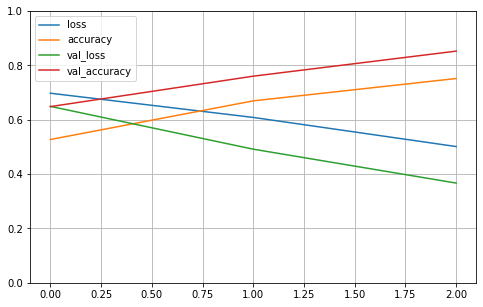

Train set ones/size 2730 / 5725
Compute valiation accuracy
Valid sizes (4992, 4997) (4992,)
Valid set ones/size 2342 / 4992
Range of scores: 0.0013744772 to 0.99523574
Score threshold 0.5
Prediction set ones/size 2221 / 4992


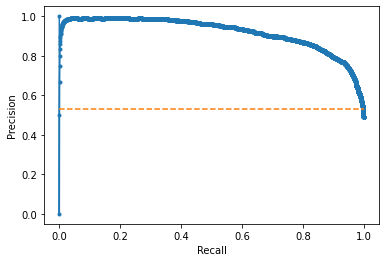

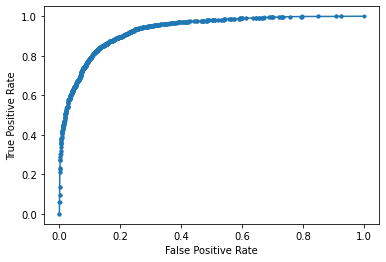

Accuracy: 85.24% Precision: 86.13% Recall: 81.68%
F1: 83.85% AUPRC: 91.98% AUROC: 93.00%
2023-02-06 13:02:54.643035
Fold 3
Model params (mean 0.24, wgt 0.38) (mean -2.21, wgt 0.62)
RCI threshold derived from training set: [-1.28186]
FIT
2023-02-06 13:02:59.634360
PREDICT
2023-02-06 13:03:08.183704


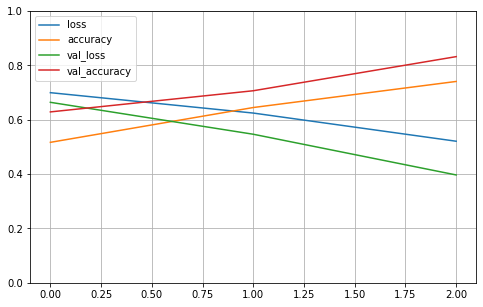

Train set ones/size 2759 / 5722
Compute valiation accuracy
Valid sizes (4932, 4997) (4932,)
Valid set ones/size 2407 / 4932
Range of scores: 0.002759186 to 0.9958515
Score threshold 0.5
Prediction set ones/size 2559 / 4932


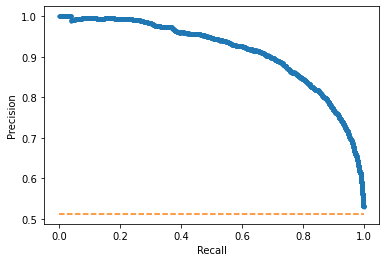

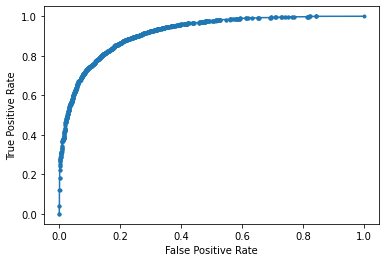

Accuracy: 83.21% Precision: 80.85% Recall: 85.96%
F1: 83.33% AUPRC: 91.36% AUROC: 91.64%
2023-02-06 13:03:09.451680
Fold 4
Model params (mean -2.20, wgt 0.62) (mean 0.25, wgt 0.38)
RCI threshold derived from training set: [-1.27365873]
FIT
2023-02-06 13:03:13.987180
PREDICT
2023-02-06 13:03:24.845113


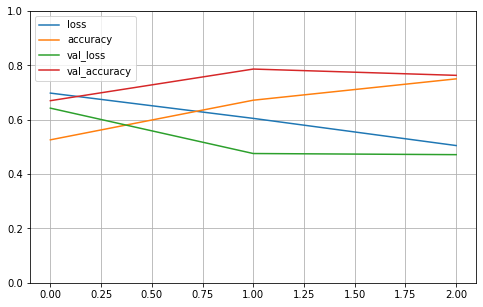

Train set ones/size 2737 / 5728
Compute valiation accuracy
Valid sizes (4967, 4997) (4967,)
Valid set ones/size 2385 / 4967
Range of scores: 0.008817862 to 0.99834776
Score threshold 0.5
Prediction set ones/size 3361 / 4967


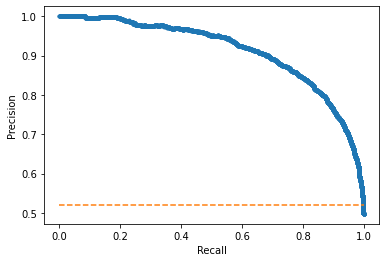

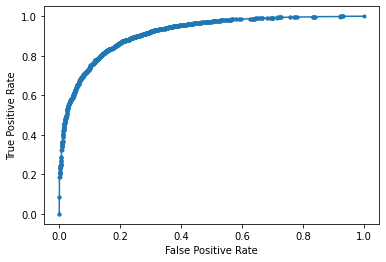

Accuracy: 76.32% Precision: 67.99% Recall: 95.81%
F1: 79.53% AUPRC: 91.21% AUROC: 91.54%
2023-02-06 13:03:26.046906
Fold 5
Model params (mean -2.20, wgt 0.62) (mean 0.25, wgt 0.38)
RCI threshold derived from training set: [-1.27856204]
FIT
2023-02-06 13:03:30.409984
PREDICT
2023-02-06 13:03:39.308514


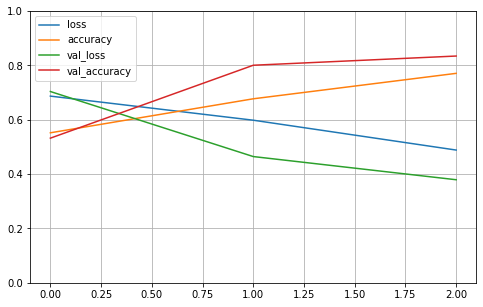

Train set ones/size 2759 / 5715
Compute valiation accuracy
Valid sizes (4961, 4997) (4961,)
Valid set ones/size 2453 / 4961
Range of scores: 0.0022057425 to 0.99599177
Score threshold 0.5
Prediction set ones/size 2927 / 4961


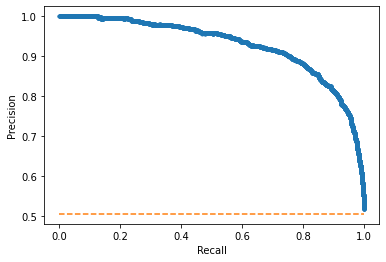

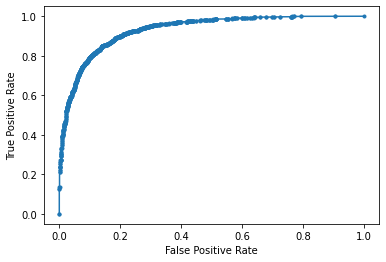

Accuracy: 83.43% Precision: 77.86% Recall: 92.91%
F1: 84.72% AUPRC: 92.84% AUROC: 93.06%
2023-02-06 13:03:40.486301

Completed cross validation 5 folds 3 epochs
 accuracy mean 82.45% +/- 3.14
 precision mean 79.15% +/- 6.20
 recall mean 88.15% +/- 5.33
 F1 mean 83.02% +/- 1.80
 AUPRC mean 91.80% +/- 0.59
 AUROC mean 92.28% +/- 0.65
Finished cell Line 2 HeLa.S3

2023-02-06 13:03:41.805515
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-06 13:03:58.310124
splitting
Fold 1
Model params (mean 0.22, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.07268512]
FIT
2023-02-06 13:04:04.750123
PREDICT
2023-02-06 13:04:25.975332


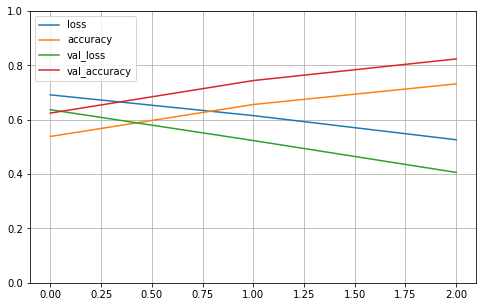

Train set ones/size 3973 / 8290
Compute valiation accuracy
Valid sizes (7229, 4997) (7229,)
Valid set ones/size 3451 / 7229
Range of scores: 0.0058491817 to 0.99399155
Score threshold 0.5
Prediction set ones/size 3940 / 7229


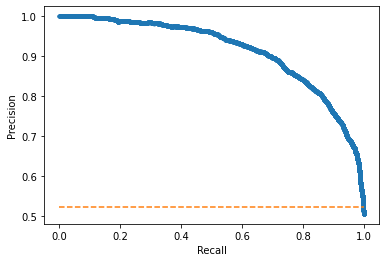

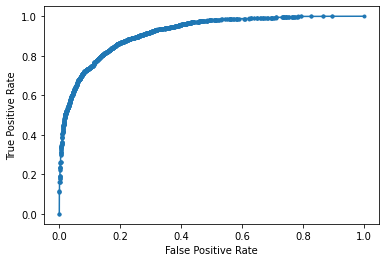

Accuracy: 82.36% Precision: 77.61% Recall: 88.61%
F1: 82.75% AUPRC: 91.39% AUROC: 91.78%
2023-02-06 13:04:28.085454
Fold 2
Model params (mean 0.21, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.07617401]
FIT
2023-02-06 13:04:34.133360
PREDICT
2023-02-06 13:04:55.342167


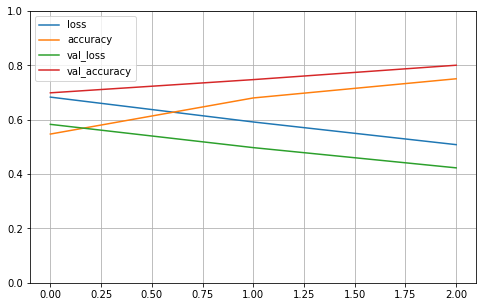

Train set ones/size 3959 / 8278
Compute valiation accuracy
Valid sizes (7158, 4997) (7158,)
Valid set ones/size 3369 / 7158
Range of scores: 0.0007030553 to 0.99472445
Score threshold 0.5
Prediction set ones/size 2171 / 7158


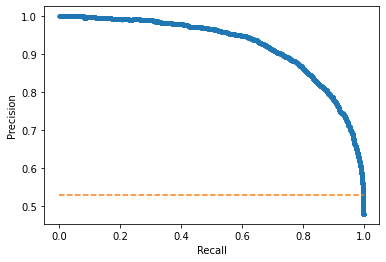

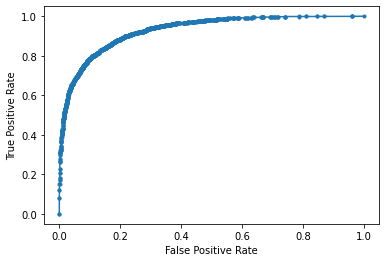

Accuracy: 80.05% Precision: 94.70% Recall: 61.03%
F1: 74.22% AUPRC: 92.44% AUROC: 92.91%
2023-02-06 13:04:56.803683
Fold 3
Model params (mean -1.89, wgt 0.61) (mean 0.21, wgt 0.39)
RCI threshold derived from training set: [-1.07502257]
FIT
2023-02-06 13:05:02.766961
PREDICT
2023-02-06 13:05:14.398538


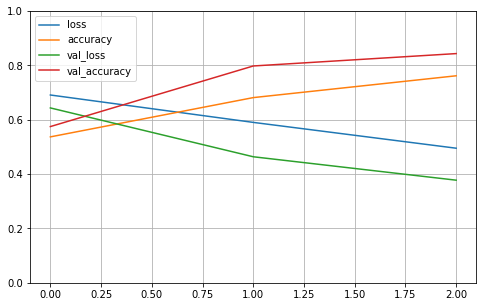

Train set ones/size 3973 / 8298
Compute valiation accuracy
Valid sizes (7243, 4997) (7243,)
Valid set ones/size 3464 / 7243
Range of scores: 0.0025698976 to 0.9990356
Score threshold 0.5
Prediction set ones/size 3869 / 7243


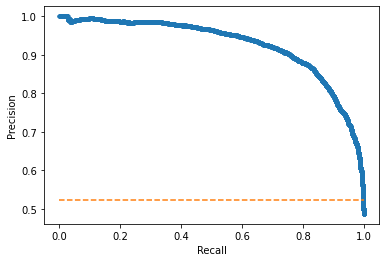

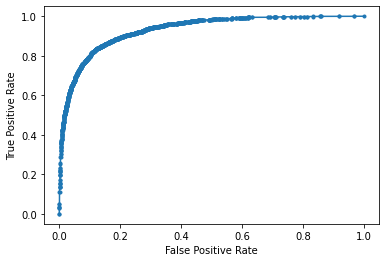

Accuracy: 84.33% Precision: 80.10% Recall: 89.46%
F1: 84.52% AUPRC: 92.62% AUROC: 93.13%
2023-02-06 13:05:15.829510
Fold 4
Model params (mean 0.19, wgt 0.39) (mean -1.89, wgt 0.61)
RCI threshold derived from training set: [-1.07579793]
FIT
2023-02-06 13:05:23.301879
PREDICT
2023-02-06 13:05:35.017076


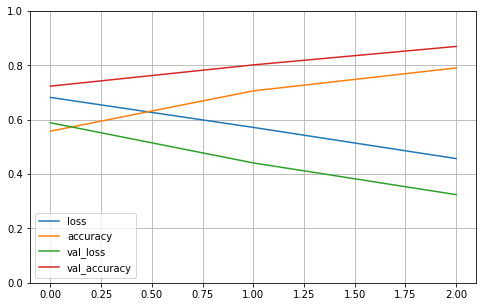

Train set ones/size 3981 / 8300
Compute valiation accuracy
Valid sizes (7080, 4997) (7080,)
Valid set ones/size 3357 / 7080
Range of scores: 0.0010193018 to 0.99856997
Score threshold 0.5
Prediction set ones/size 3698 / 7080


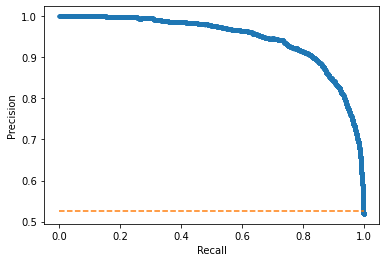

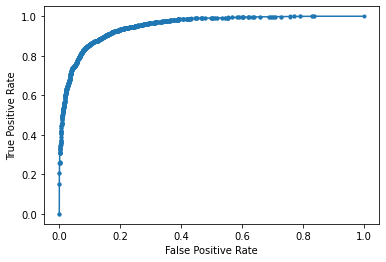

Accuracy: 86.96% Precision: 82.91% Recall: 91.33%
F1: 86.92% AUPRC: 94.67% AUROC: 95.05%
2023-02-06 13:05:36.947277
Fold 5
Model params (mean -1.88, wgt 0.61) (mean 0.19, wgt 0.39)
RCI threshold derived from training set: [-1.07598466]
FIT
2023-02-06 13:05:42.736449
PREDICT
2023-02-06 13:06:03.951867


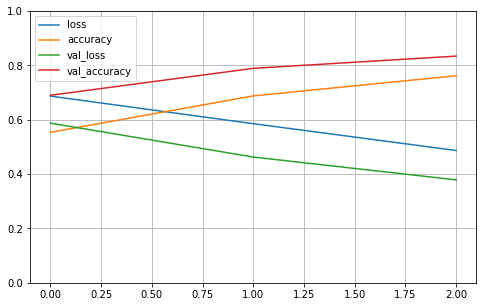

Train set ones/size 3976 / 8294
Compute valiation accuracy
Valid sizes (7063, 4997) (7063,)
Valid set ones/size 3406 / 7063
Range of scores: 0.0029420154 to 0.9979305
Score threshold 0.5
Prediction set ones/size 2770 / 7063


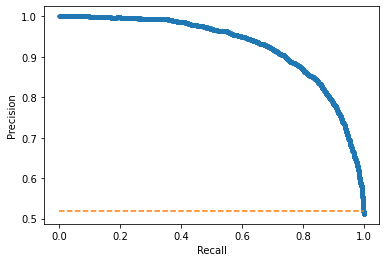

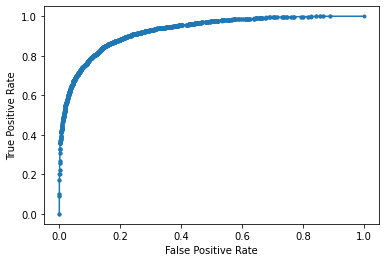

Accuracy: 83.41% Precision: 90.32% Recall: 73.46%
F1: 81.02% AUPRC: 92.74% AUROC: 92.64%
2023-02-06 13:06:05.396560

Completed cross validation 5 folds 3 epochs
 accuracy mean 83.42% +/- 2.27
 precision mean 85.13% +/- 6.41
 recall mean 80.78% +/- 11.76
 F1 mean 81.89% +/- 4.30
 AUPRC mean 92.77% +/- 1.06
 AUROC mean 93.10% +/- 1.08
Finished cell Line 3 HepG2

2023-02-06 13:06:06.769104
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-06 13:06:18.543434
splitting
Fold 1
Model params (mean 0.96, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.27746276]
FIT
2023-02-06 13:06:22.346013
PREDICT
2023-02-06 13:06:33.356350


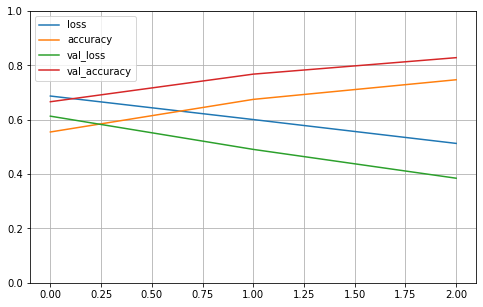

Train set ones/size 3350 / 6978
Compute valiation accuracy
Valid sizes (6174, 4997) (6174,)
Valid set ones/size 2902 / 6174
Range of scores: 0.0028278357 to 0.9960045
Score threshold 0.5
Prediction set ones/size 2510 / 6174


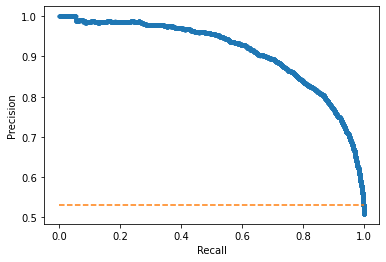

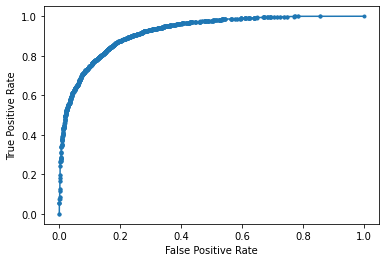

Accuracy: 82.83% Precision: 86.69% Recall: 74.98%
F1: 80.41% AUPRC: 91.22% AUROC: 92.08%
2023-02-06 13:06:35.229742
Fold 2
Model params (mean -1.02, wgt 0.63) (mean 0.97, wgt 0.37)
RCI threshold derived from training set: [-0.28321335]
FIT
2023-02-06 13:06:42.172567
PREDICT
2023-02-06 13:06:52.994949


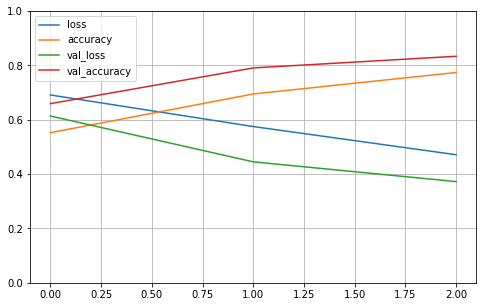

Train set ones/size 3345 / 6971
Compute valiation accuracy
Valid sizes (6131, 4997) (6131,)
Valid set ones/size 2925 / 6131
Range of scores: 0.00026609172 to 0.99070346
Score threshold 0.5
Prediction set ones/size 2210 / 6131


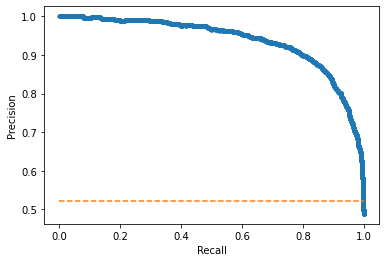

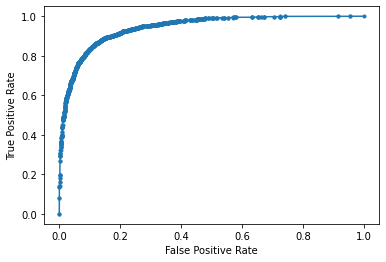

Accuracy: 83.35% Precision: 93.08% Recall: 70.32%
F1: 80.12% AUPRC: 93.73% AUROC: 94.24%
2023-02-06 13:06:55.086904
Fold 3
Model params (mean 0.97, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.27943614]
FIT
2023-02-06 13:07:00.351835
PREDICT
2023-02-06 13:07:10.525959


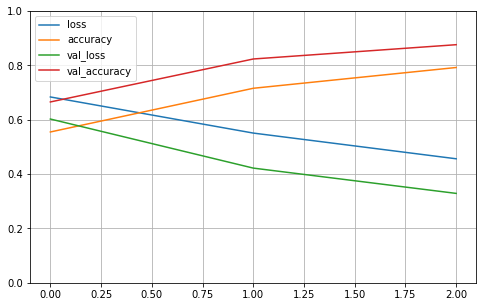

Train set ones/size 3357 / 6985
Compute valiation accuracy
Valid sizes (6219, 4997) (6219,)
Valid set ones/size 2899 / 6219
Range of scores: 0.0012112004 to 0.9948715
Score threshold 0.5
Prediction set ones/size 2944 / 6219


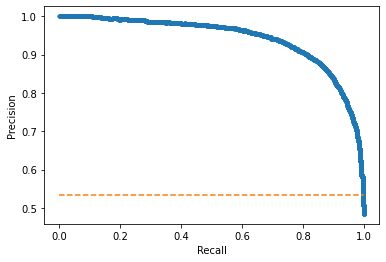

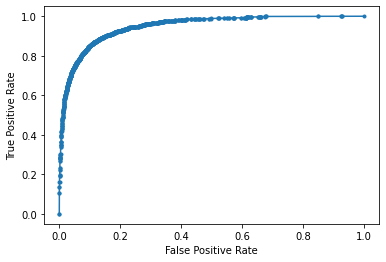

Accuracy: 87.60% Precision: 86.14% Recall: 87.48%
F1: 86.80% AUPRC: 94.17% AUROC: 94.80%
2023-02-06 13:07:12.390271
Fold 4
Model params (mean 0.97, wgt 0.37) (mean -1.02, wgt 0.63)
RCI threshold derived from training set: [-0.28167804]
FIT
2023-02-06 13:07:17.709000
PREDICT
2023-02-06 13:07:28.290595


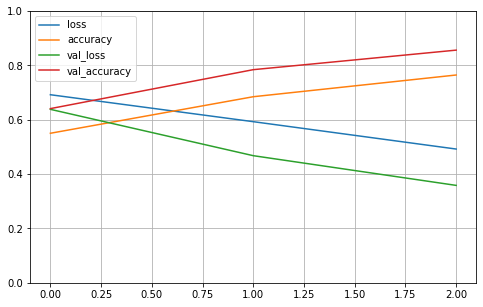

Train set ones/size 3349 / 6969
Compute valiation accuracy
Valid sizes (6259, 4997) (6259,)
Valid set ones/size 2983 / 6259
Range of scores: 0.0036435972 to 0.99818796
Score threshold 0.5
Prediction set ones/size 3330 / 6259


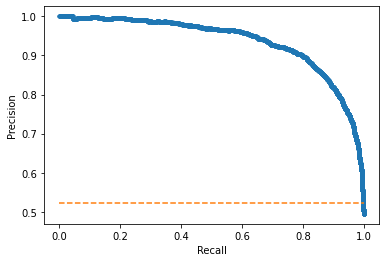

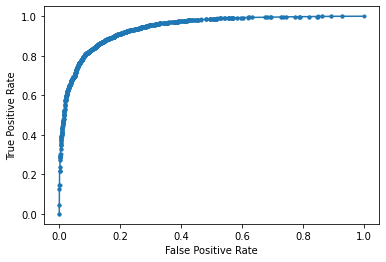

Accuracy: 85.60% Precision: 81.26% Recall: 90.71%
F1: 85.73% AUPRC: 93.59% AUROC: 94.02%
2023-02-06 13:07:29.592311
Fold 5
Model params (mean -1.02, wgt 0.63) (mean 0.98, wgt 0.37)
RCI threshold derived from training set: [-0.27713261]
FIT
2023-02-06 13:07:36.764104
PREDICT
2023-02-06 13:07:47.709920


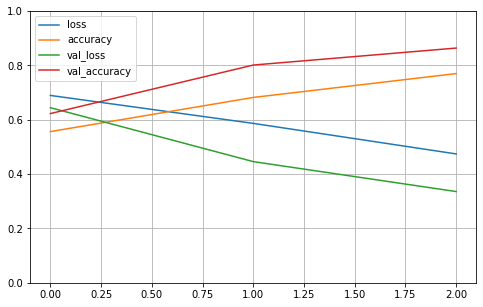

Train set ones/size 3346 / 6971
Compute valiation accuracy
Valid sizes (6211, 4997) (6211,)
Valid set ones/size 2926 / 6211
Range of scores: 0.0006105004 to 0.9977196
Score threshold 0.5
Prediction set ones/size 2705 / 6211


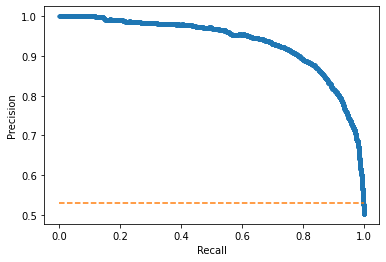

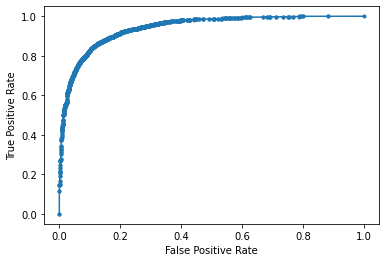

Accuracy: 86.36% Precision: 88.43% Recall: 81.75%
F1: 84.96% AUPRC: 93.49% AUROC: 94.14%
2023-02-06 13:07:49.118530

Completed cross validation 5 folds 3 epochs
 accuracy mean 85.15% +/- 1.81
 precision mean 87.12% +/- 3.81
 recall mean 81.05% +/- 7.58
 F1 mean 83.60% +/- 2.79
 AUPRC mean 93.24% +/- 1.04
 AUROC mean 93.85% +/- 0.93
Finished cell Line 4 HT1080

2023-02-06 13:07:50.464375
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-06 13:08:06.303041
splitting
Fold 1
Model params (mean -0.01, wgt 0.53) (mean -2.00, wgt 0.47)
RCI threshold derived from training set: [-0.95271667]
FIT
2023-02-06 13:08:11.315800
PREDICT
2023-02-06 13:08:32.504801


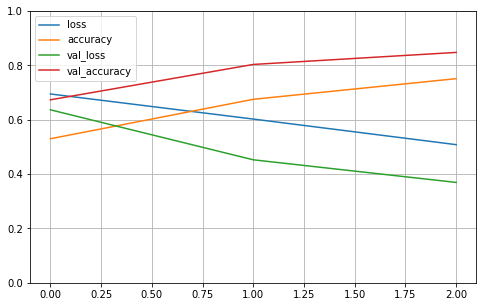

Train set ones/size 4802 / 9440
Compute valiation accuracy
Valid sizes (8060, 4997) (8060,)
Valid set ones/size 4177 / 8060
Range of scores: 0.0008456672 to 0.99522984
Score threshold 0.5
Prediction set ones/size 4461 / 8060


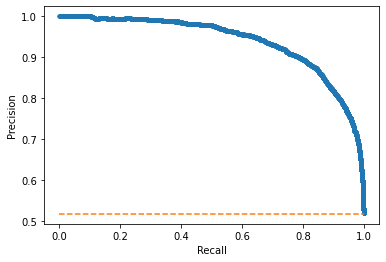

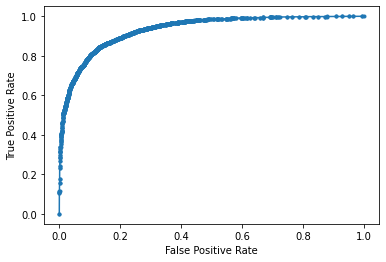

Accuracy: 84.76% Precision: 83.05% Recall: 88.70%
F1: 85.78% AUPRC: 93.89% AUROC: 93.29%
2023-02-06 13:08:34.118288
Fold 2
Model params (mean -0.01, wgt 0.53) (mean -2.00, wgt 0.47)
RCI threshold derived from training set: [-0.95006585]
FIT
2023-02-06 13:08:42.115160
PREDICT
2023-02-06 13:09:03.326511


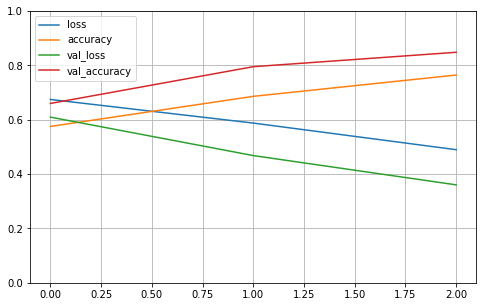

Train set ones/size 4810 / 9437
Compute valiation accuracy
Valid sizes (8151, 4997) (8151,)
Valid set ones/size 4135 / 8151
Range of scores: 1.45602135e-05 to 0.9979037
Score threshold 0.5
Prediction set ones/size 4259 / 8151


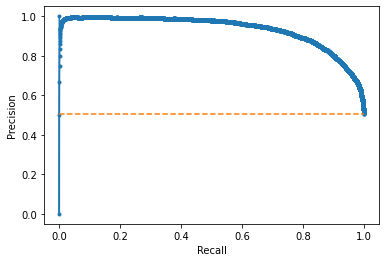

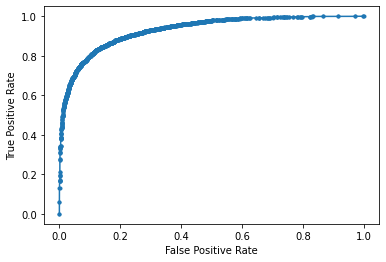

Accuracy: 84.81% Precision: 84.01% Recall: 86.53%
F1: 85.25% AUPRC: 93.48% AUROC: 93.00%
2023-02-06 13:09:05.055839
Fold 3
Model params (mean -0.00, wgt 0.53) (mean -2.01, wgt 0.47)
RCI threshold derived from training set: [-0.95126426]
FIT
2023-02-06 13:09:12.225403
PREDICT
2023-02-06 13:09:24.454062


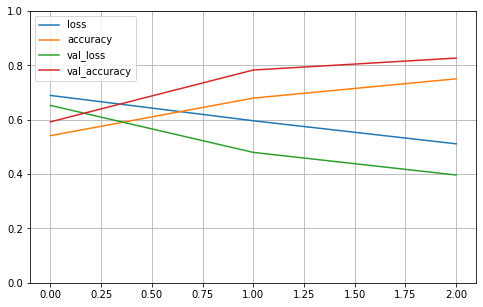

Train set ones/size 4816 / 9440
Compute valiation accuracy
Valid sizes (8242, 4997) (8242,)
Valid set ones/size 4234 / 8242
Range of scores: 0.00014225811 to 0.99102354
Score threshold 0.5
Prediction set ones/size 3372 / 8242


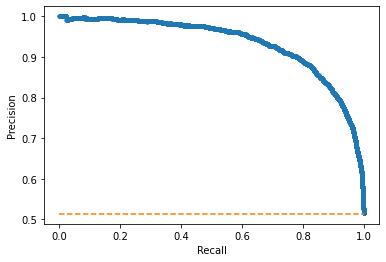

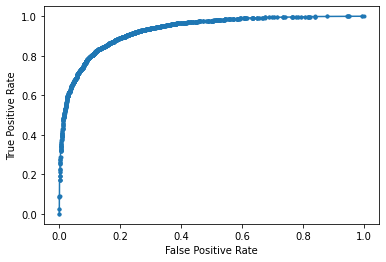

Accuracy: 82.67% Precision: 91.61% Recall: 72.96%
F1: 81.23% AUPRC: 93.41% AUROC: 92.93%
2023-02-06 13:09:26.027760
Fold 4
Model params (mean -1.99, wgt 0.48) (mean 0.02, wgt 0.52)
RCI threshold derived from training set: [-0.93757094]
FIT
2023-02-06 13:09:33.170157
PREDICT
2023-02-06 13:09:54.667595


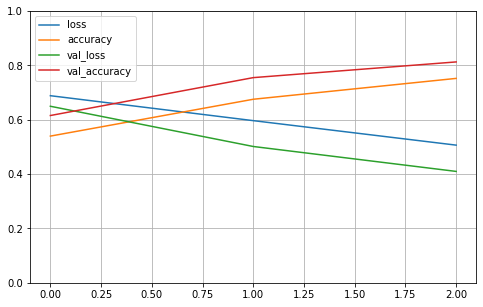

Train set ones/size 4777 / 9405
Compute valiation accuracy
Valid sizes (8204, 4997) (8204,)
Valid set ones/size 4120 / 8204
Range of scores: 0.0022007853 to 0.997191
Score threshold 0.5
Prediction set ones/size 5299 / 8204


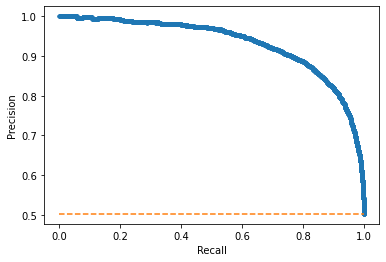

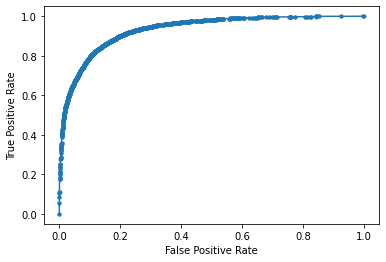

Accuracy: 81.27% Precision: 74.37% Recall: 95.66%
F1: 83.68% AUPRC: 93.26% AUROC: 93.18%
2023-02-06 13:09:56.596062
Fold 5
Model params (mean -0.01, wgt 0.53) (mean -2.01, wgt 0.47)
RCI threshold derived from training set: [-0.94847185]
FIT
2023-02-06 13:10:04.480536
PREDICT
2023-02-06 13:10:16.962441


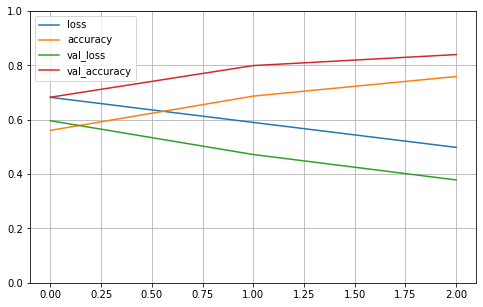

Train set ones/size 4817 / 9435
Compute valiation accuracy
Valid sizes (8177, 4997) (8177,)
Valid set ones/size 4168 / 8177
Range of scores: 0.00011688366 to 0.9965042
Score threshold 0.5
Prediction set ones/size 4937 / 8177


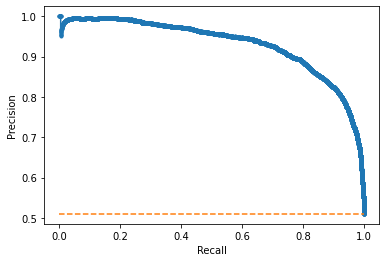

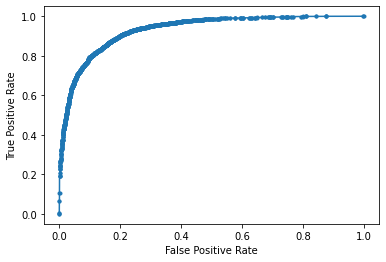

Accuracy: 83.97% Precision: 78.93% Recall: 93.50%
F1: 85.60% AUPRC: 93.16% AUROC: 93.14%
2023-02-06 13:10:18.495889

Completed cross validation 5 folds 3 epochs
 accuracy mean 83.50% +/- 1.36
 precision mean 82.40% +/- 5.73
 recall mean 87.47% +/- 7.95
 F1 mean 84.31% +/- 1.71
 AUPRC mean 93.44% +/- 0.25
 AUROC mean 93.11% +/- 0.13
Finished cell Line 5 HUVEC

2023-02-06 13:10:19.898055
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-06 13:10:37.884777
splitting
Fold 1
Model params (mean -0.07, wgt 0.49) (mean -2.11, wgt 0.51)
RCI threshold derived from training set: [-1.11312475]
FIT
2023-02-06 13:10:45.708900
PREDICT
2023-02-06 13:11:00.515387


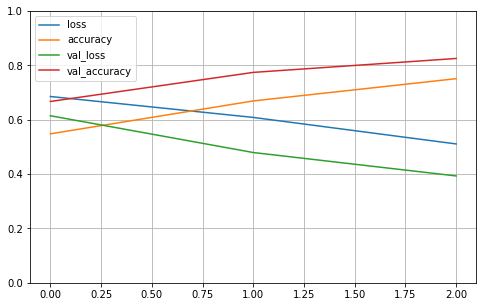

Train set ones/size 5799 / 11321
Compute valiation accuracy
Valid sizes (9350, 4997) (9350,)
Valid set ones/size 4911 / 9350
Range of scores: 0.0009025228 to 0.9992861
Score threshold 0.5
Prediction set ones/size 3862 / 9350


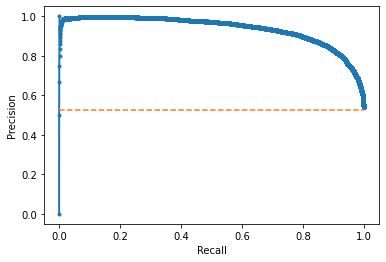

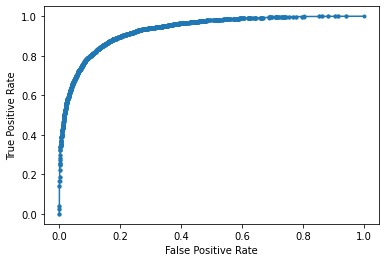

Accuracy: 82.53% Precision: 92.44% Recall: 72.69%
F1: 81.39% AUPRC: 93.72% AUROC: 93.11%
2023-02-06 13:11:02.422536
Fold 2
Model params (mean -0.07, wgt 0.49) (mean -2.10, wgt 0.51)
RCI threshold derived from training set: [-1.10998594]
FIT
2023-02-06 13:11:11.397640
PREDICT
2023-02-06 13:11:27.195655


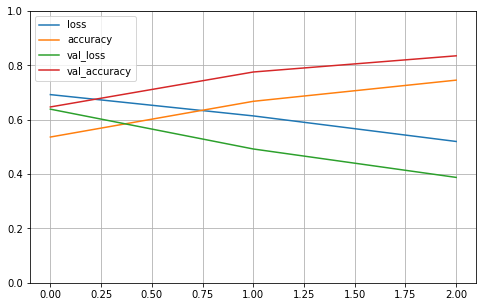

Train set ones/size 5785 / 11294
Compute valiation accuracy
Valid sizes (9486, 4997) (9486,)
Valid set ones/size 4909 / 9486
Range of scores: 0.0019452984 to 0.9945581
Score threshold 0.5
Prediction set ones/size 4077 / 9486


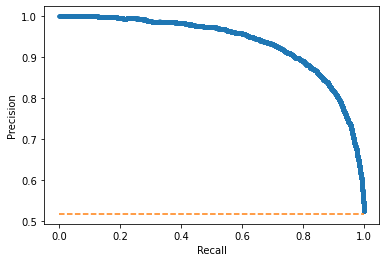

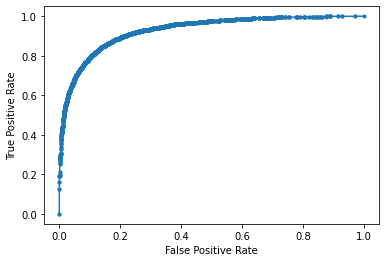

Accuracy: 83.51% Precision: 91.02% Recall: 75.60%
F1: 82.60% AUPRC: 93.63% AUROC: 92.86%
2023-02-06 13:11:28.894549
Fold 3
Model params (mean -0.06, wgt 0.49) (mean -2.10, wgt 0.51)
RCI threshold derived from training set: [-1.11009206]
FIT
2023-02-06 13:11:37.943342
PREDICT
2023-02-06 13:11:59.168376


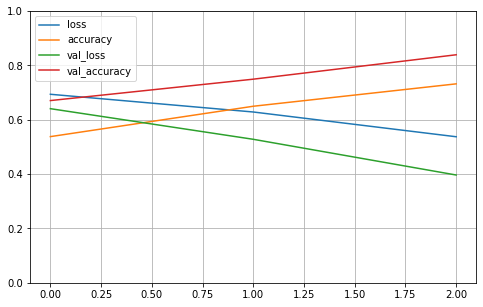

Train set ones/size 5801 / 11309
Compute valiation accuracy
Valid sizes (9365, 4997) (9365,)
Valid set ones/size 4827 / 9365
Range of scores: 0.0030925456 to 0.98934036
Score threshold 0.5
Prediction set ones/size 4271 / 9365


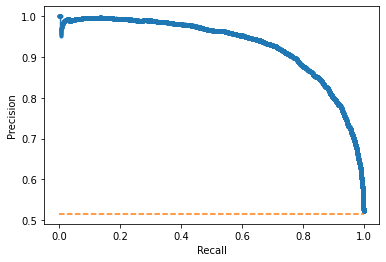

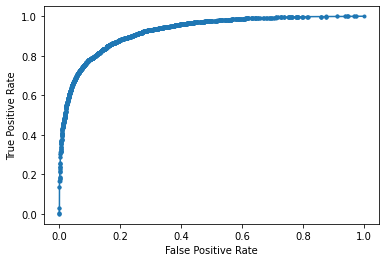

Accuracy: 83.90% Precision: 88.86% Recall: 78.62%
F1: 83.42% AUPRC: 93.10% AUROC: 92.50%
2023-02-06 13:12:01.369497
Fold 4
Model params (mean -2.10, wgt 0.52) (mean -0.06, wgt 0.48)
RCI threshold derived from training set: [-1.1109806]
FIT
2023-02-06 13:12:08.881321
PREDICT
2023-02-06 13:12:23.638643


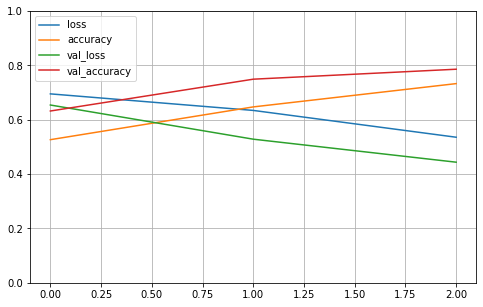

Train set ones/size 5769 / 11271
Compute valiation accuracy
Valid sizes (9463, 4997) (9463,)
Valid set ones/size 4900 / 9463
Range of scores: 0.0033644803 to 0.99494416
Score threshold 0.5
Prediction set ones/size 6453 / 9463


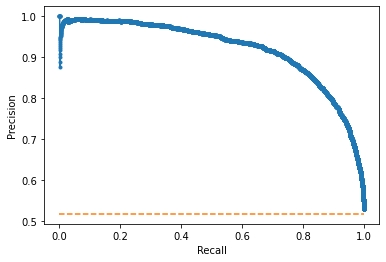

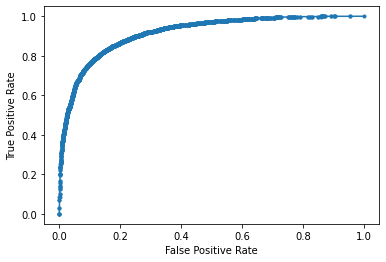

Accuracy: 78.58% Precision: 72.26% Recall: 95.16%
F1: 82.15% AUPRC: 92.10% AUROC: 91.64%
2023-02-06 13:12:25.747525
Fold 5
Model params (mean -2.11, wgt 0.51) (mean -0.07, wgt 0.49)
RCI threshold derived from training set: [-1.11451616]
FIT
2023-02-06 13:12:33.630699
PREDICT
2023-02-06 13:12:54.874849


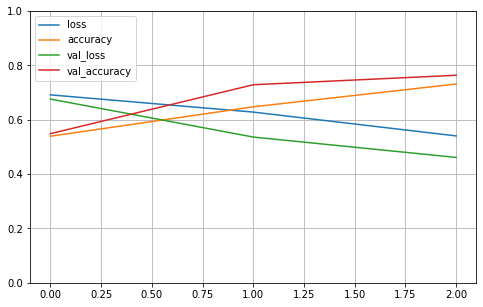

Train set ones/size 5778 / 11268
Compute valiation accuracy
Valid sizes (9410, 4997) (9410,)
Valid set ones/size 4886 / 9410
Range of scores: 0.00367479 to 0.9966156
Score threshold 0.5
Prediction set ones/size 6739 / 9410


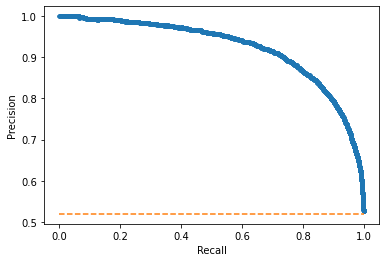

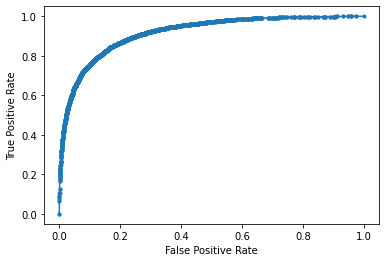

Accuracy: 76.35% Precision: 69.74% Recall: 96.19%
F1: 80.86% AUPRC: 92.38% AUROC: 91.68%
2023-02-06 13:12:56.631567

Completed cross validation 5 folds 3 epochs
 accuracy mean 80.98% +/- 2.98
 precision mean 82.86% +/- 9.78
 recall mean 83.65% +/- 10.00
 F1 mean 82.08% +/- 0.90
 AUPRC mean 92.98% +/- 0.65
 AUROC mean 92.36% +/- 0.60
Finished cell Line 6 MCF.7

2023-02-06 13:12:58.063203
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-06 13:13:07.263888
splitting
Fold 1
Model params (mean -0.92, wgt 0.67) (mean -2.06, wgt 0.33)
RCI threshold derived from training set: [-1.29905847]
FIT
2023-02-06 13:13:10.428618
PREDICT
2023-02-06 13:13:21.365394


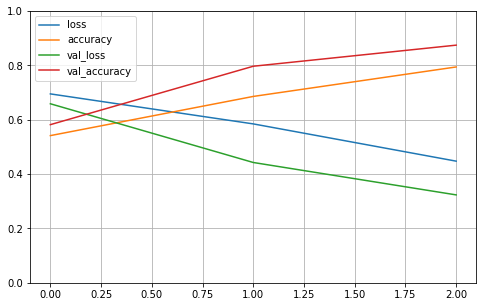

Train set ones/size 2649 / 5154
Compute valiation accuracy
Valid sizes (4704, 4997) (4704,)
Valid set ones/size 2448 / 4704
Range of scores: 0.002346865 to 0.9969739
Score threshold 0.5
Prediction set ones/size 2277 / 4704


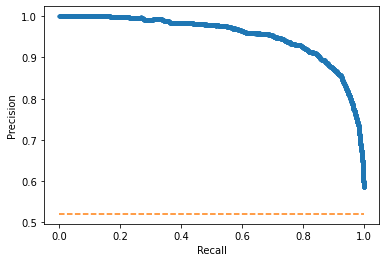

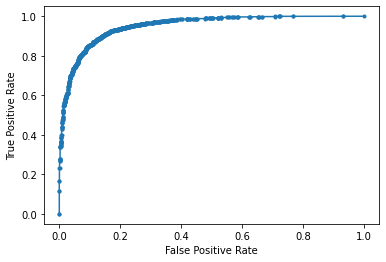

Accuracy: 87.44% Precision: 90.78% Recall: 84.44%
F1: 87.49% AUPRC: 95.33% AUROC: 95.04%
2023-02-06 13:13:22.511505
Fold 2
Model params (mean -0.89, wgt 0.56) (mean -1.80, wgt 0.44)
RCI threshold derived from training set: [-1.29488849]
FIT
2023-02-06 13:13:26.961163
PREDICT
2023-02-06 13:13:35.074266


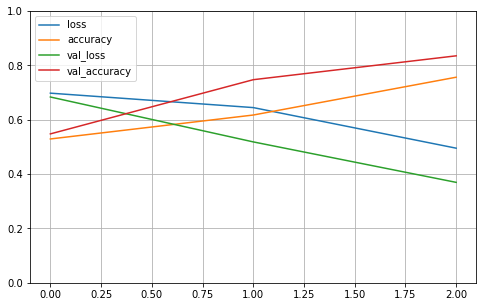

Train set ones/size 2656 / 5168
Compute valiation accuracy
Valid sizes (4669, 4997) (4669,)
Valid set ones/size 2447 / 4669
Range of scores: 0.0015360548 to 0.9980242
Score threshold 0.5
Prediction set ones/size 2919 / 4669


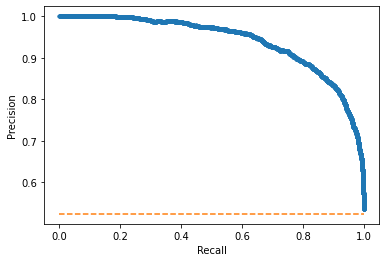

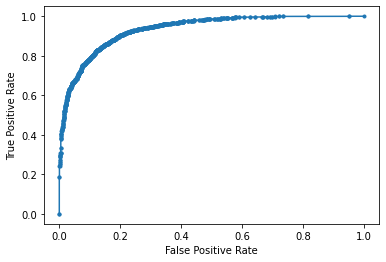

Accuracy: 83.51% Precision: 78.73% Recall: 93.91%
F1: 85.65% AUPRC: 94.05% AUROC: 93.42%
2023-02-06 13:13:36.163703
Fold 3
Model params (mean -1.76, wgt 0.51) (mean -0.82, wgt 0.49)
RCI threshold derived from training set: [-1.3021096]
FIT
2023-02-06 13:13:40.825955
PREDICT
2023-02-06 13:13:51.731437


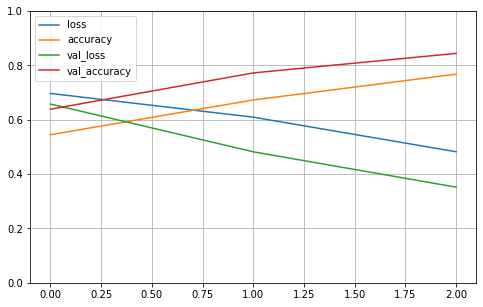

Train set ones/size 2649 / 5157
Compute valiation accuracy
Valid sizes (4727, 4997) (4727,)
Valid set ones/size 2430 / 4727
Range of scores: 0.0022070822 to 0.9981834
Score threshold 0.5
Prediction set ones/size 2589 / 4727


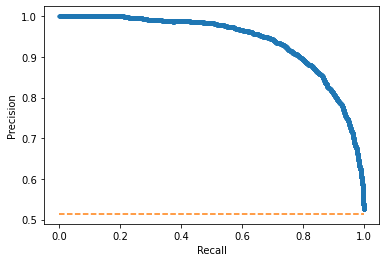

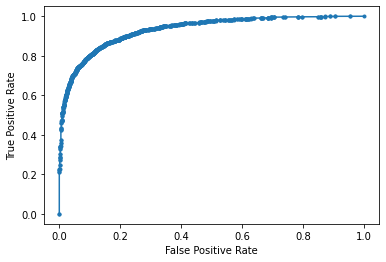

Accuracy: 84.41% Precision: 82.70% Recall: 88.11%
F1: 85.32% AUPRC: 94.03% AUROC: 93.17%
2023-02-06 13:13:52.951129
Fold 4
Model params (mean -0.87, wgt 0.55) (mean -1.85, wgt 0.45)
RCI threshold derived from training set: [-1.30550912]
FIT
2023-02-06 13:13:59.368808
PREDICT
2023-02-06 13:14:10.283039


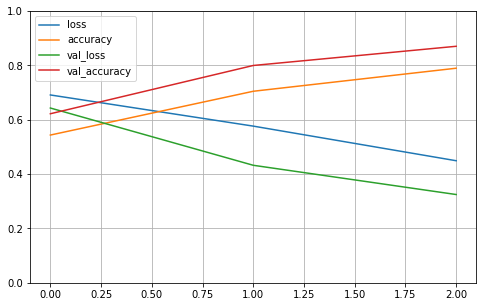

Train set ones/size 2642 / 5164
Compute valiation accuracy
Valid sizes (4645, 4997) (4645,)
Valid set ones/size 2412 / 4645
Range of scores: 0.0029885548 to 0.9992642
Score threshold 0.5
Prediction set ones/size 2375 / 4645


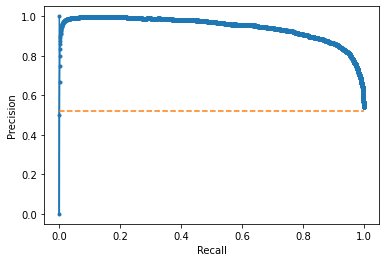

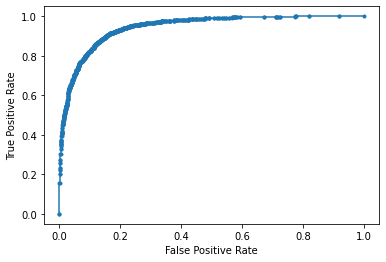

Accuracy: 87.02% Precision: 88.08% Recall: 86.73%
F1: 87.40% AUPRC: 94.39% AUROC: 94.43%
2023-02-06 13:14:12.178221
Fold 5
Model params (mean -1.99, wgt 0.35) (mean -0.94, wgt 0.65)
RCI threshold derived from training set: [-1.30514305]
FIT
2023-02-06 13:14:16.369744
PREDICT
2023-02-06 13:14:24.378443


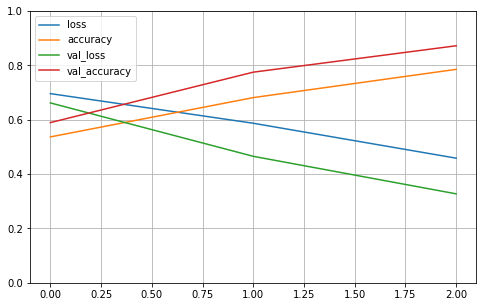

Train set ones/size 2646 / 5166
Compute valiation accuracy
Valid sizes (4644, 4997) (4644,)
Valid set ones/size 2406 / 4644
Range of scores: 0.0031458894 to 0.9953565
Score threshold 0.5
Prediction set ones/size 2150 / 4644


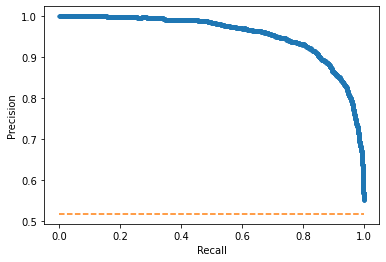

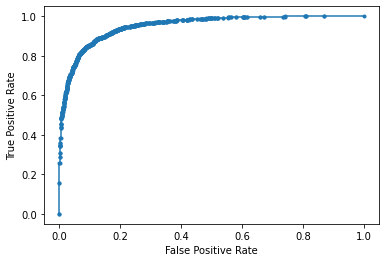

Accuracy: 87.21% Precision: 92.14% Recall: 82.34%
F1: 86.96% AUPRC: 95.54% AUROC: 95.13%
2023-02-06 13:14:25.590932

Completed cross validation 5 folds 3 epochs
 accuracy mean 85.92% +/- 1.63
 precision mean 86.48% +/- 5.05
 recall mean 87.10% +/- 3.93
 F1 mean 86.56% +/- 0.91
 AUPRC mean 94.67% +/- 0.64
 AUROC mean 94.24% +/- 0.81
Finished cell Line 7 NCI.H460

2023-02-06 13:14:26.894749
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-06 13:14:40.349327
splitting
Fold 1
Model params (mean 0.51, wgt 0.50) (mean -1.75, wgt 0.50)
RCI threshold derived from training set: [-0.63371227]
FIT
2023-02-06 13:14:45.167758
PREDICT
2023-02-06 13:14:56.463127


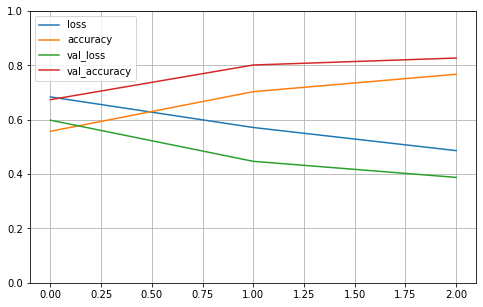

Train set ones/size 4115 / 8043
Compute valiation accuracy
Valid sizes (7102, 4997) (7102,)
Valid set ones/size 3626 / 7102
Range of scores: 0.00078844465 to 0.9993437
Score threshold 0.5
Prediction set ones/size 2963 / 7102


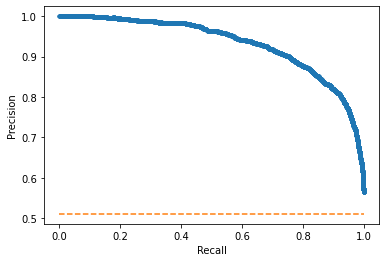

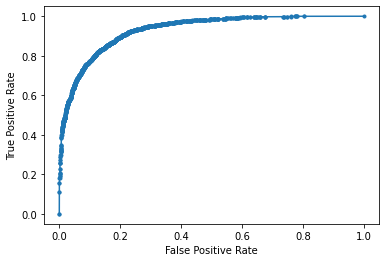

Accuracy: 82.70% Precision: 90.45% Recall: 73.91%
F1: 81.35% AUPRC: 93.30% AUROC: 93.07%
2023-02-06 13:14:58.343139
Fold 2
Model params (mean 0.51, wgt 0.50) (mean -1.77, wgt 0.50)
RCI threshold derived from training set: [-0.63660023]
FIT
2023-02-06 13:15:05.786850
PREDICT
2023-02-06 13:15:17.529369


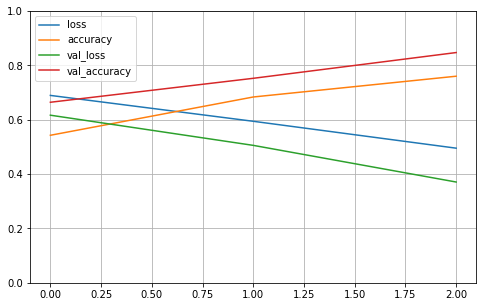

Train set ones/size 4109 / 8035
Compute valiation accuracy
Valid sizes (7124, 4997) (7124,)
Valid set ones/size 3687 / 7124
Range of scores: 0.001634394 to 0.9951715
Score threshold 0.5
Prediction set ones/size 3902 / 7124


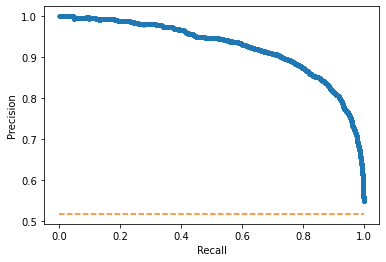

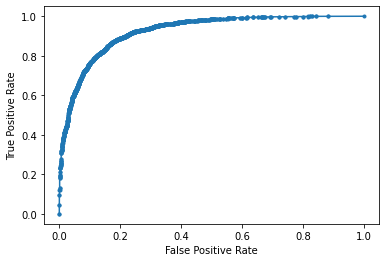

Accuracy: 84.71% Precision: 83.29% Recall: 88.15%
F1: 85.65% AUPRC: 92.49% AUROC: 92.37%
2023-02-06 13:15:18.998759
Fold 3
Model params (mean -1.78, wgt 0.50) (mean 0.49, wgt 0.50)
RCI threshold derived from training set: [-0.63652781]
FIT
2023-02-06 13:15:25.193658
PREDICT
2023-02-06 13:15:46.371639


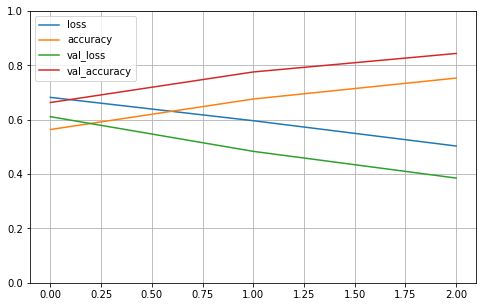

Train set ones/size 4098 / 8017
Compute valiation accuracy
Valid sizes (7151, 4997) (7151,)
Valid set ones/size 3682 / 7151
Range of scores: 0.0014052264 to 0.9916814
Score threshold 0.5
Prediction set ones/size 3565 / 7151


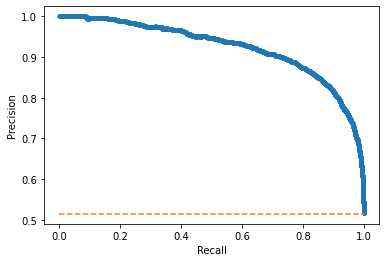

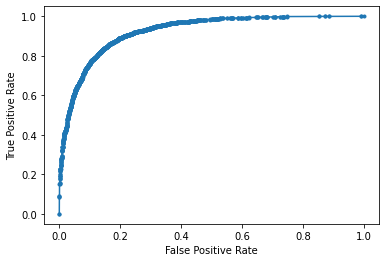

Accuracy: 84.38% Precision: 85.97% Recall: 83.24%
F1: 84.59% AUPRC: 92.37% AUROC: 92.34%
2023-02-06 13:15:48.249257
Fold 4
Model params (mean 0.49, wgt 0.50) (mean -1.79, wgt 0.50)
RCI threshold derived from training set: [-0.63720198]
FIT
2023-02-06 13:15:55.026161
PREDICT
2023-02-06 13:16:06.515647


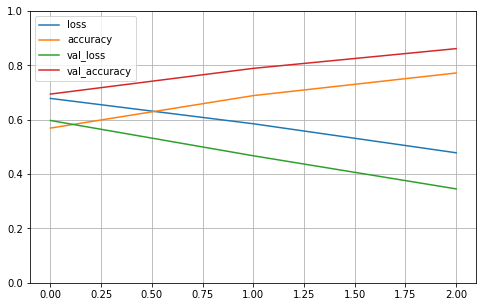

Train set ones/size 4100 / 8024
Compute valiation accuracy
Valid sizes (7093, 4997) (7093,)
Valid set ones/size 3688 / 7093
Range of scores: 0.0010991357 to 0.99986756
Score threshold 0.5
Prediction set ones/size 3916 / 7093


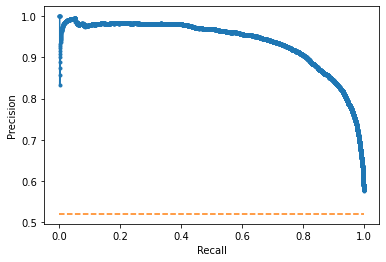

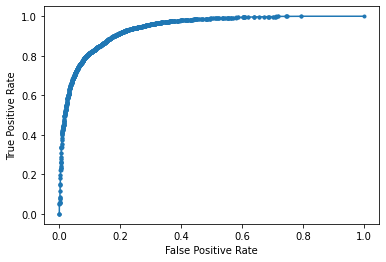

Accuracy: 86.16% Precision: 84.55% Recall: 89.78%
F1: 87.09% AUPRC: 93.83% AUROC: 93.93%
2023-02-06 13:16:08.576304
Fold 5
Model params (mean -1.75, wgt 0.51) (mean 0.51, wgt 0.49)
RCI threshold derived from training set: [-0.63788826]
FIT
2023-02-06 13:16:14.352695
PREDICT
2023-02-06 13:16:35.546917


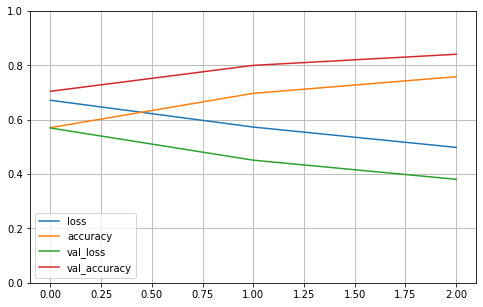

Train set ones/size 4105 / 8036
Compute valiation accuracy
Valid sizes (7085, 4997) (7085,)
Valid set ones/size 3595 / 7085
Range of scores: 0.0007063541 to 0.99328023
Score threshold 0.5
Prediction set ones/size 2987 / 7085


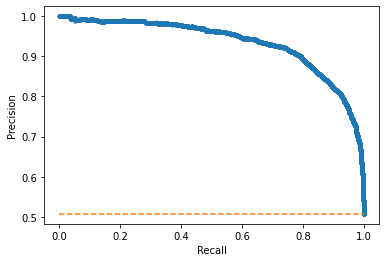

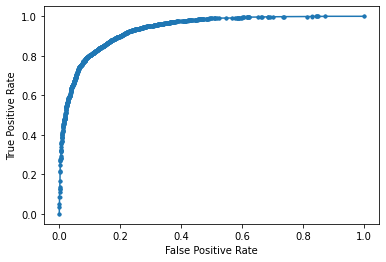

Accuracy: 84.08% Precision: 91.30% Recall: 75.86%
F1: 82.86% AUPRC: 93.44% AUROC: 93.48%
2023-02-06 13:16:37.039000

Completed cross validation 5 folds 3 epochs
 accuracy mean 84.40% +/- 1.11
 precision mean 87.11% +/- 3.20
 recall mean 82.19% +/- 6.37
 F1 mean 84.31% +/- 2.02
 AUPRC mean 93.09% +/- 0.57
 AUROC mean 93.04% +/- 0.62
Finished cell Line 8 NHEK

2023-02-06 13:16:38.408936
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-06 13:16:46.150615
splitting
Fold 1
Model params (mean -2.59, wgt 0.42) (mean -0.89, wgt 0.58)
RCI threshold derived from training set: [-1.61000527]
FIT
2023-02-06 13:16:50.451646
PREDICT
2023-02-06 13:17:01.374884


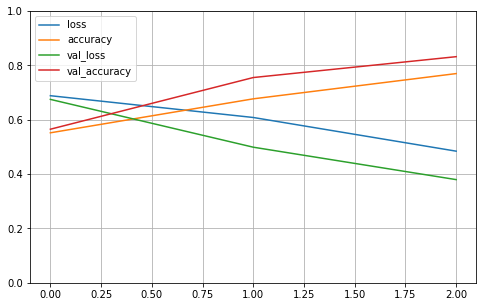

Train set ones/size 2676 / 5103
Compute valiation accuracy
Valid sizes (4665, 4997) (4665,)
Valid set ones/size 2411 / 4665
Range of scores: 0.004814201 to 0.99750525
Score threshold 0.5
Prediction set ones/size 2843 / 4665


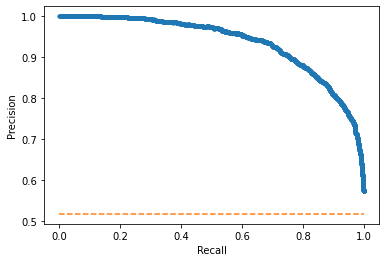

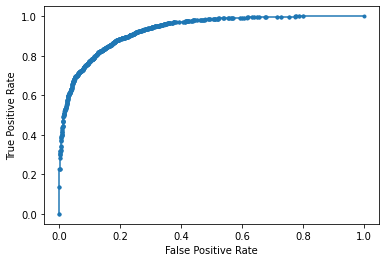

Accuracy: 83.19% Precision: 78.61% Recall: 92.70%
F1: 85.08% AUPRC: 93.60% AUROC: 93.05%
2023-02-06 13:17:02.560549
Fold 2
Model params (mean -0.90, wgt 0.58) (mean -2.59, wgt 0.42)
RCI threshold derived from training set: [-1.6056254]
FIT
2023-02-06 13:17:06.868518
PREDICT
2023-02-06 13:17:17.770150


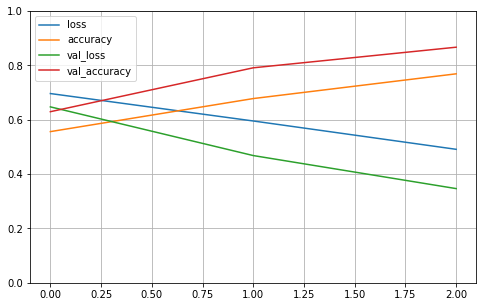

Train set ones/size 2675 / 5097
Compute valiation accuracy
Valid sizes (4618, 4997) (4618,)
Valid set ones/size 2415 / 4618
Range of scores: 0.0013910109 to 0.99830997
Score threshold 0.5
Prediction set ones/size 2434 / 4618


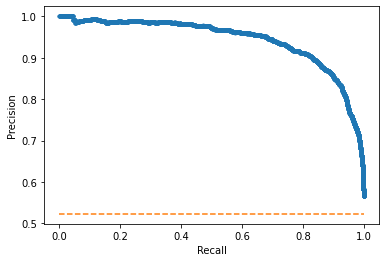

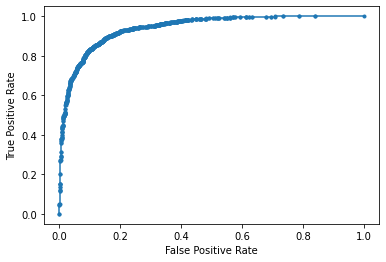

Accuracy: 86.68% Precision: 86.98% Recall: 87.66%
F1: 87.32% AUPRC: 94.37% AUROC: 94.14%
2023-02-06 13:17:18.970865
Fold 3
Model params (mean -0.89, wgt 0.57) (mean -2.58, wgt 0.43)
RCI threshold derived from training set: [-1.61101464]
FIT
2023-02-06 13:17:23.496761
PREDICT
2023-02-06 13:17:34.416681


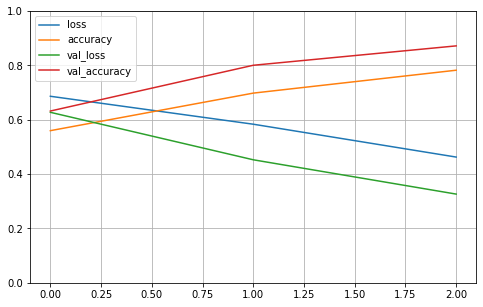

Train set ones/size 2681 / 5104
Compute valiation accuracy
Valid sizes (4668, 4997) (4668,)
Valid set ones/size 2460 / 4668
Range of scores: 0.00095385883 to 0.9980381
Score threshold 0.5
Prediction set ones/size 2475 / 4668


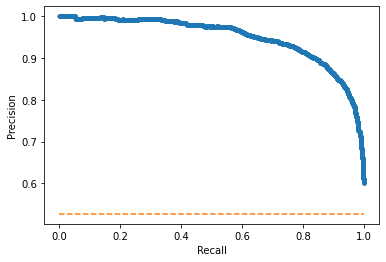

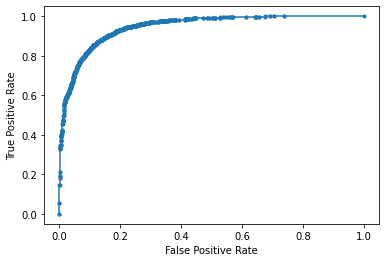

Accuracy: 87.17% Precision: 87.60% Recall: 88.13%
F1: 87.86% AUPRC: 94.95% AUROC: 94.65%
2023-02-06 13:17:35.582107
Fold 4
Model params (mean -0.90, wgt 0.58) (mean -2.58, wgt 0.42)
RCI threshold derived from training set: [-1.61368018]
FIT
2023-02-06 13:17:41.717493
PREDICT
2023-02-06 13:17:48.793119


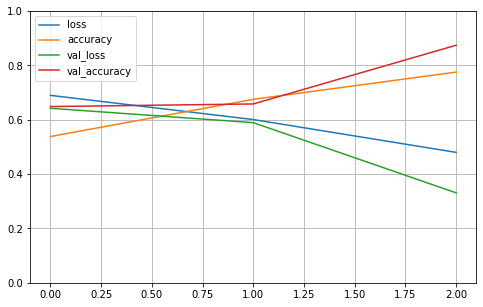

Train set ones/size 2679 / 5095
Compute valiation accuracy
Valid sizes (4693, 4997) (4693,)
Valid set ones/size 2486 / 4693
Range of scores: 0.0010291669 to 0.9986545
Score threshold 0.5
Prediction set ones/size 2607 / 4693


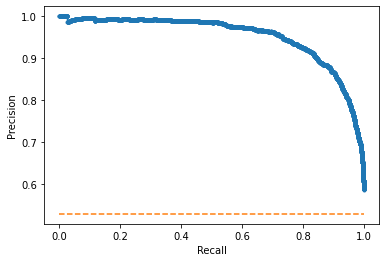

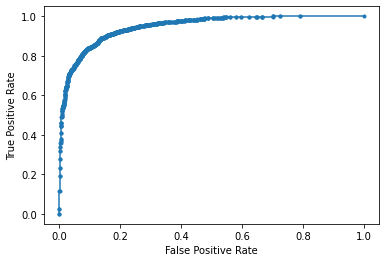

Accuracy: 87.41% Precision: 86.34% Recall: 90.55%
F1: 88.40% AUPRC: 95.31% AUROC: 94.79%
2023-02-06 13:17:49.908728
Fold 5
Model params (mean -2.58, wgt 0.43) (mean -0.89, wgt 0.57)
RCI threshold derived from training set: [-1.60905084]
FIT
2023-02-06 13:17:55.231677
PREDICT
2023-02-06 13:18:06.143224


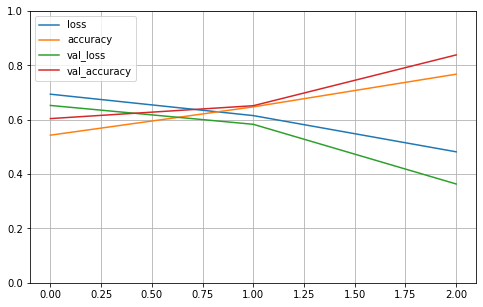

Train set ones/size 2667 / 5089
Compute valiation accuracy
Valid sizes (4580, 4997) (4580,)
Valid set ones/size 2359 / 4580
Range of scores: 0.0006294652 to 0.99643433
Score threshold 0.5
Prediction set ones/size 1881 / 4580


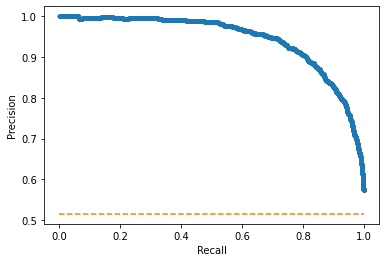

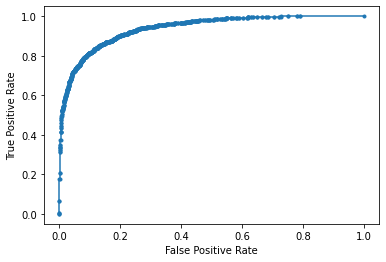

Accuracy: 83.84% Precision: 93.04% Recall: 74.18%
F1: 82.55% AUPRC: 94.48% AUROC: 93.87%
2023-02-06 13:18:07.308134

Completed cross validation 5 folds 3 epochs
 accuracy mean 85.66% +/- 1.78
 precision mean 86.51% +/- 4.61
 recall mean 86.64% +/- 6.49
 F1 mean 86.24% +/- 2.16
 AUPRC mean 94.54% +/- 0.58
 AUROC mean 94.10% +/- 0.62
Finished cell Line 9 SK.MEL.5

2023-02-06 13:18:08.602680
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-06 13:18:17.639052
splitting
Fold 1
Model params (mean -0.21, wgt 0.64) (mean -1.36, wgt 0.36)
RCI threshold derived from training set: [-0.61868146]
FIT
2023-02-06 13:18:21.889786
PREDICT
2023-02-06 13:18:31.005274


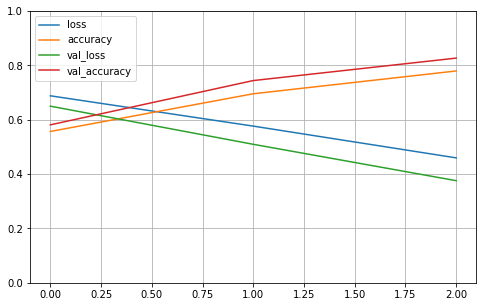

Train set ones/size 3276 / 5724
Compute valiation accuracy
Valid sizes (5314, 4997) (5314,)
Valid set ones/size 3060 / 5314
Range of scores: 0.00054803607 to 0.99980503
Score threshold 0.5
Prediction set ones/size 3819 / 5314


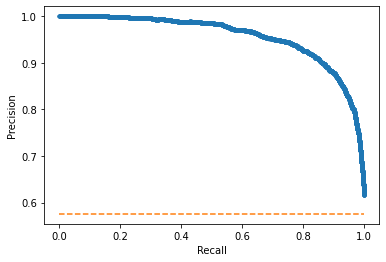

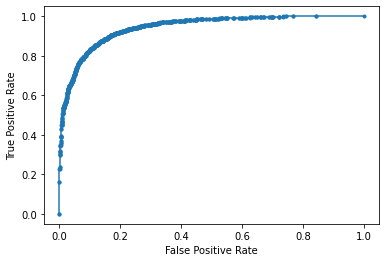

Accuracy: 82.67% Precision: 78.00% Recall: 97.35%
F1: 86.61% AUPRC: 95.71% AUROC: 94.31%
2023-02-06 13:18:32.569946
Fold 2
Model params (mean -1.73, wgt 0.22) (mean -0.31, wgt 0.78)
RCI threshold derived from training set: [-0.61945256]
FIT
2023-02-06 13:18:37.287819
PREDICT
2023-02-06 13:18:46.382044


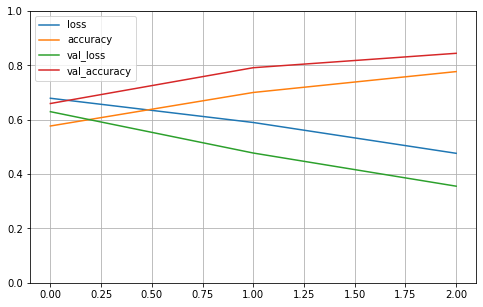

Train set ones/size 3270 / 5715
Compute valiation accuracy
Valid sizes (5153, 4997) (5153,)
Valid set ones/size 2915 / 5153
Range of scores: 0.00012309865 to 0.99967873
Score threshold 0.5
Prediction set ones/size 3439 / 5153


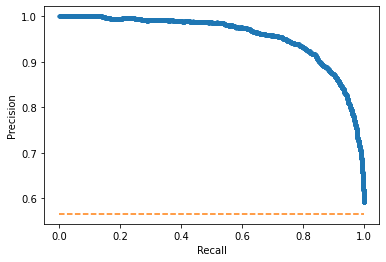

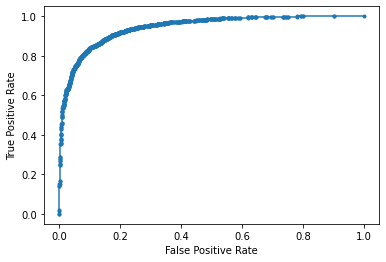

Accuracy: 84.44% Precision: 80.72% Recall: 95.23%
F1: 87.38% AUPRC: 95.63% AUROC: 94.35%
2023-02-06 13:18:47.540633
Fold 3
Model params (mean -0.31, wgt 0.78) (mean -1.73, wgt 0.22)
RCI threshold derived from training set: [-0.61982647]
FIT
2023-02-06 13:18:52.414814
PREDICT
2023-02-06 13:19:01.616302


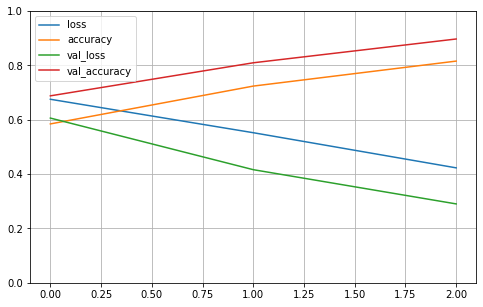

Train set ones/size 3271 / 5719
Compute valiation accuracy
Valid sizes (5254, 4997) (5254,)
Valid set ones/size 2977 / 5254
Range of scores: 0.0018035251 to 0.99891496
Score threshold 0.5
Prediction set ones/size 2838 / 5254


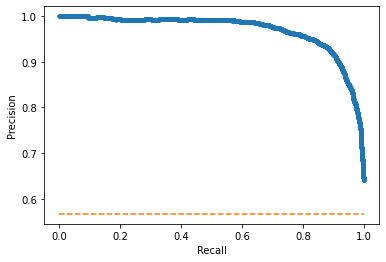

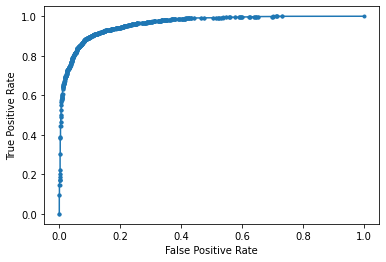

Accuracy: 89.70% Precision: 92.92% Recall: 88.58%
F1: 90.70% AUPRC: 96.94% AUROC: 96.10%
2023-02-06 13:19:02.817549
Fold 4
Model params (mean -0.31, wgt 0.78) (mean -1.73, wgt 0.22)
RCI threshold derived from training set: [-0.61740207]
FIT
2023-02-06 13:19:07.499997
PREDICT
2023-02-06 13:19:16.718278


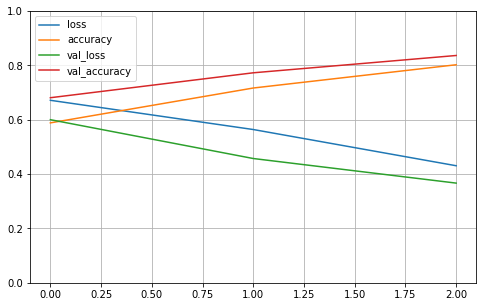

Train set ones/size 3272 / 5714
Compute valiation accuracy
Valid sizes (5278, 4997) (5278,)
Valid set ones/size 3002 / 5278
Range of scores: 0.00020910706 to 0.99906975
Score threshold 0.5
Prediction set ones/size 2312 / 5278


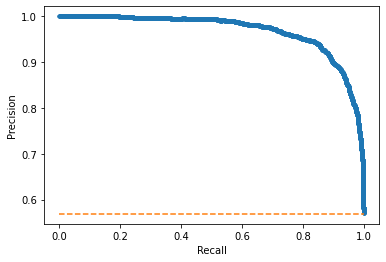

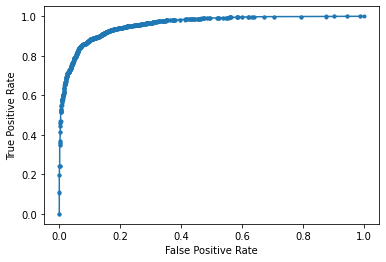

Accuracy: 83.63% Precision: 96.24% Recall: 74.12%
F1: 83.74% AUPRC: 96.79% AUROC: 95.71%
2023-02-06 13:19:17.935429
Fold 5
Model params (mean -1.36, wgt 0.36) (mean -0.20, wgt 0.64)
RCI threshold derived from training set: [-0.61836196]
FIT
2023-02-06 13:19:22.909661
PREDICT
2023-02-06 13:19:32.327416


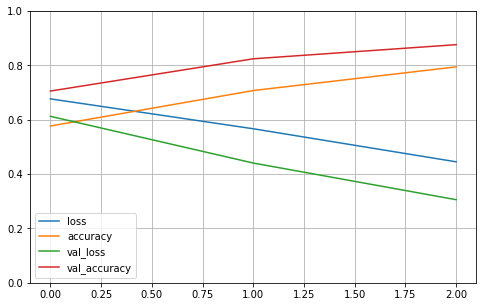

Train set ones/size 3275 / 5721
Compute valiation accuracy
Valid sizes (5191, 4997) (5191,)
Valid set ones/size 2927 / 5191
Range of scores: 0.00028630954 to 0.99931836
Score threshold 0.5
Prediction set ones/size 3158 / 5191


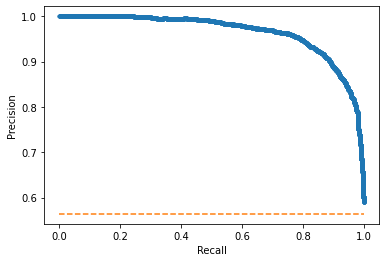

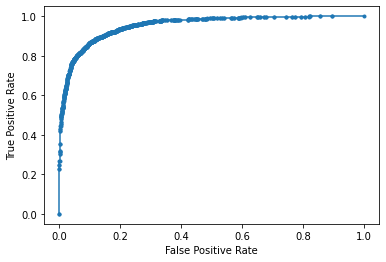

Accuracy: 87.61% Precision: 86.16% Recall: 92.96%
F1: 89.43% AUPRC: 96.45% AUROC: 95.37%
2023-02-06 13:19:33.560940

Completed cross validation 5 folds 3 epochs
 accuracy mean 85.61% +/- 2.64
 precision mean 86.81% +/- 6.95
 recall mean 89.65% +/- 8.29
 F1 mean 87.57% +/- 2.40
 AUPRC mean 96.30% +/- 0.54
 AUROC mean 95.17% +/- 0.73
Finished cell Line 10 SK.N.DZ

2023-02-06 13:19:34.885320
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-06 13:19:53.347794
splitting
Fold 1
Model params (mean -1.86, wgt 0.47) (mean -0.14, wgt 0.53)
RCI threshold derived from training set: [-0.94930094]
FIT
2023-02-06 13:19:58.692286
PREDICT
2023-02-06 13:20:12.260939


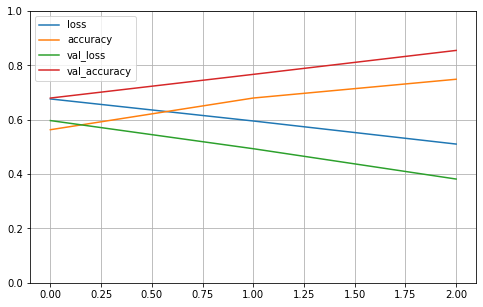

Train set ones/size 5252 / 10163
Compute valiation accuracy
Valid sizes (8751, 4997) (8751,)
Valid set ones/size 4556 / 8751
Range of scores: 0.0012512797 to 0.9945945
Score threshold 0.5
Prediction set ones/size 4875 / 8751


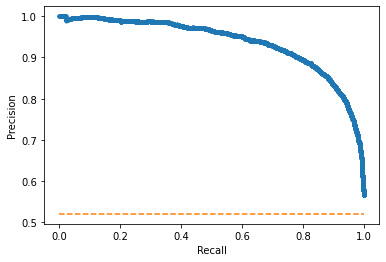

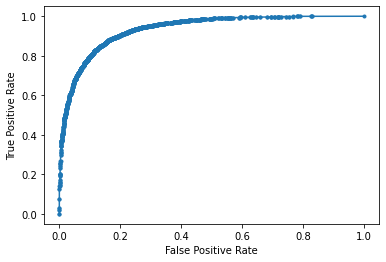

Accuracy: 85.50% Precision: 83.71% Recall: 89.57%
F1: 86.54% AUPRC: 93.73% AUROC: 93.45%
2023-02-06 13:20:13.912009
Fold 2
Model params (mean -0.13, wgt 0.53) (mean -1.86, wgt 0.47)
RCI threshold derived from training set: [-0.946003]
FIT
2023-02-06 13:20:22.707619
PREDICT
2023-02-06 13:20:43.939433


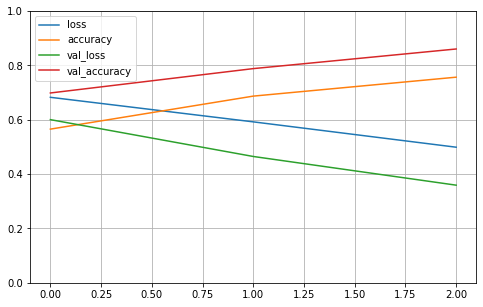

Train set ones/size 5254 / 10177
Compute valiation accuracy
Valid sizes (8723, 4997) (8723,)
Valid set ones/size 4544 / 8723
Range of scores: 0.0012142401 to 0.99784064
Score threshold 0.5
Prediction set ones/size 4407 / 8723


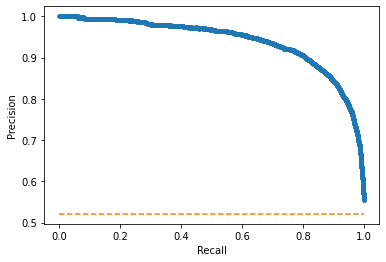

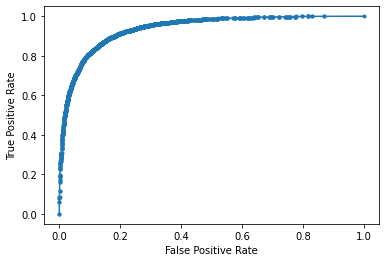

Accuracy: 86.03% Precision: 87.72% Recall: 85.08%
F1: 86.38% AUPRC: 93.97% AUROC: 93.72%
2023-02-06 13:20:46.122833
Fold 3
Model params (mean -1.87, wgt 0.47) (mean -0.13, wgt 0.53)
RCI threshold derived from training set: [-0.94835124]
FIT
2023-02-06 13:20:53.514901
PREDICT
2023-02-06 13:21:14.739572


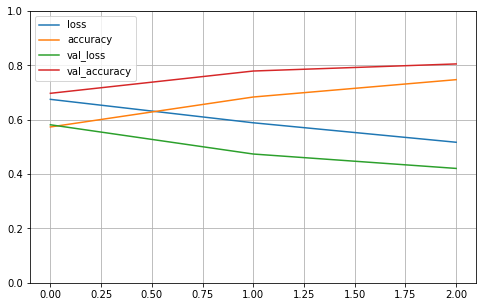

Train set ones/size 5240 / 10170
Compute valiation accuracy
Valid sizes (8853, 4997) (8853,)
Valid set ones/size 4570 / 8853
Range of scores: 0.0022401707 to 0.9977447
Score threshold 0.5
Prediction set ones/size 5696 / 8853


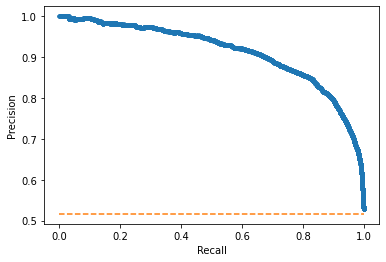

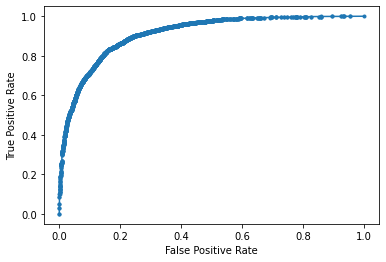

Accuracy: 80.53% Precision: 74.98% Recall: 93.46%
F1: 83.21% AUPRC: 91.30% AUROC: 91.16%
2023-02-06 13:21:16.685893
Fold 4
Model params (mean -0.13, wgt 0.53) (mean -1.87, wgt 0.47)
RCI threshold derived from training set: [-0.94885432]
FIT
2023-02-06 13:21:25.661868
PREDICT
2023-02-06 13:21:46.868508


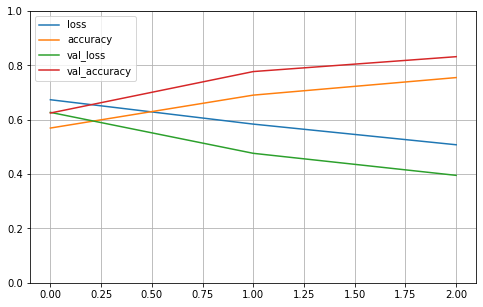

Train set ones/size 5250 / 10161
Compute valiation accuracy
Valid sizes (8729, 4997) (8729,)
Valid set ones/size 4524 / 8729
Range of scores: 0.0035456656 to 0.9950003
Score threshold 0.5
Prediction set ones/size 4447 / 8729


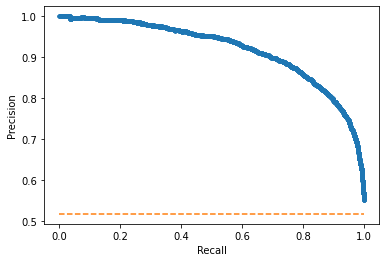

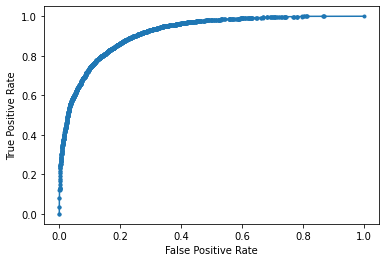

Accuracy: 83.19% Precision: 84.37% Recall: 82.94%
F1: 83.65% AUPRC: 91.99% AUROC: 91.66%
2023-02-06 13:21:48.915928
Fold 5
Model params (mean -0.13, wgt 0.53) (mean -1.86, wgt 0.47)
RCI threshold derived from training set: [-0.94554725]
FIT
2023-02-06 13:21:58.397487
PREDICT
2023-02-06 13:22:12.068804


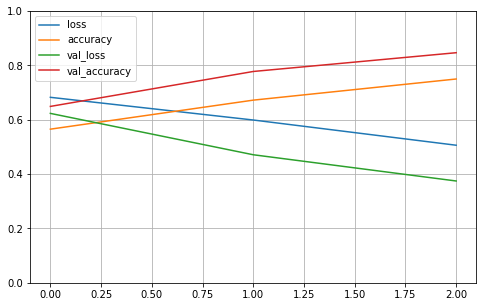

Train set ones/size 5254 / 10169
Compute valiation accuracy
Valid sizes (8836, 4997) (8836,)
Valid set ones/size 4568 / 8836
Range of scores: 0.00036864114 to 0.9969939
Score threshold 0.5
Prediction set ones/size 4162 / 8836


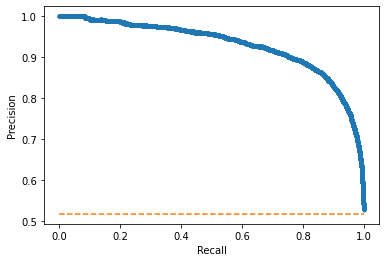

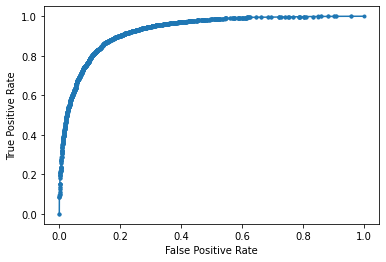

Accuracy: 84.65% Precision: 88.59% Recall: 80.71%
F1: 84.47% AUPRC: 92.93% AUROC: 92.88%
2023-02-06 13:22:14.005798

Completed cross validation 5 folds 3 epochs
 accuracy mean 83.98% +/- 1.97
 precision mean 83.88% +/- 4.82
 recall mean 86.35% +/- 4.60
 F1 mean 84.85% +/- 1.38
 AUPRC mean 92.78% +/- 1.02
 AUROC mean 92.57% +/- 1.00
Finished cell Line 11 SK.N.SH

2023-02-06 13:22:15.420095
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-06 13:22:30.985379
splitting
Fold 1
Model params (mean -0.17, wgt 0.47) (mean -1.32, wgt 0.53)
RCI threshold derived from training set: [-0.77665382]
FIT
2023-02-06 13:22:37.839749
PREDICT
2023-02-06 13:22:51.053445


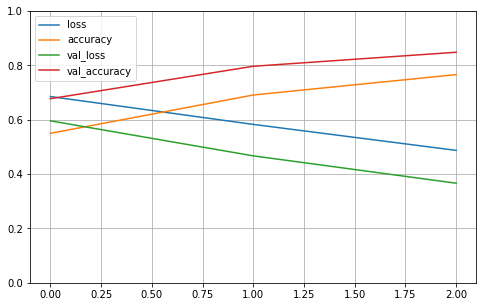

Train set ones/size 4880 / 9630
Compute valiation accuracy
Valid sizes (8296, 4997) (8296,)
Valid set ones/size 4227 / 8296
Range of scores: 0.0019274161 to 0.99901974
Score threshold 0.5
Prediction set ones/size 4572 / 8296


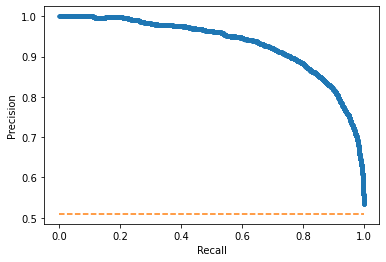

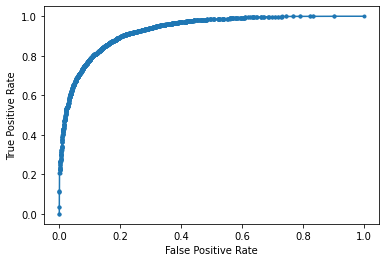

Accuracy: 84.82% Precision: 82.46% Recall: 89.19%
F1: 85.69% AUPRC: 93.16% AUROC: 92.97%
2023-02-06 13:22:52.646930
Fold 2
Model params (mean -1.31, wgt 0.52) (mean -0.18, wgt 0.48)
RCI threshold derived from training set: [-0.77313285]
FIT
2023-02-06 13:23:00.822916
PREDICT
2023-02-06 13:23:13.811846


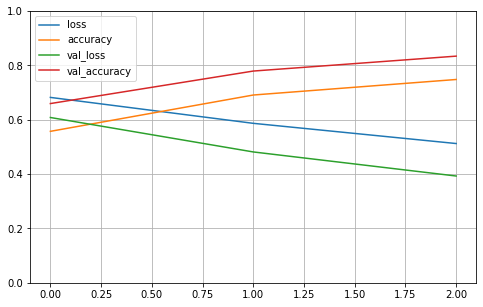

Train set ones/size 4880 / 9608
Compute valiation accuracy
Valid sizes (8142, 4997) (8142,)
Valid set ones/size 4114 / 8142
Range of scores: 0.0064810934 to 0.9964887
Score threshold 0.5
Prediction set ones/size 4112 / 8142


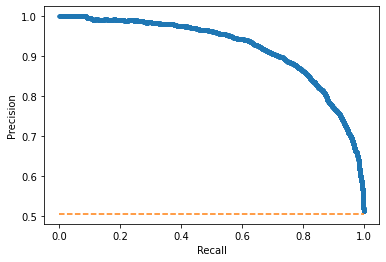

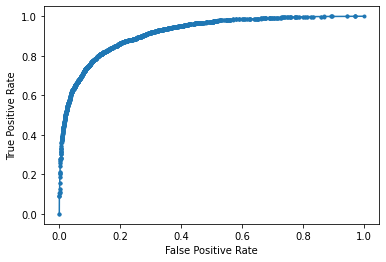

Accuracy: 83.39% Precision: 83.58% Recall: 83.54%
F1: 83.56% AUPRC: 92.14% AUROC: 91.67%
2023-02-06 13:23:15.677699
Fold 3
Model params (mean -0.17, wgt 0.47) (mean -1.32, wgt 0.53)
RCI threshold derived from training set: [-0.77664902]
FIT
2023-02-06 13:23:22.283622
PREDICT
2023-02-06 13:23:35.040511


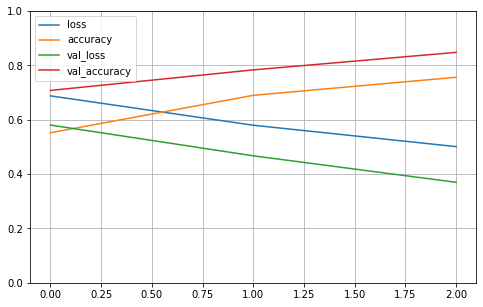

Train set ones/size 4878 / 9630
Compute valiation accuracy
Valid sizes (8110, 4997) (8110,)
Valid set ones/size 4158 / 8110
Range of scores: 0.002451858 to 0.99548787
Score threshold 0.5
Prediction set ones/size 3778 / 8110


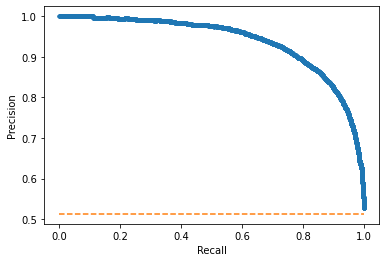

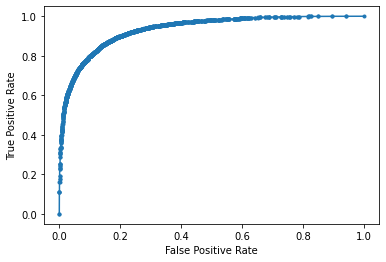

Accuracy: 84.78% Precision: 88.70% Recall: 80.59%
F1: 84.45% AUPRC: 93.89% AUROC: 93.38%
2023-02-06 13:23:36.588172
Fold 4
Model params (mean -0.17, wgt 0.47) (mean -1.33, wgt 0.53)
RCI threshold derived from training set: [-0.77518304]
FIT
2023-02-06 13:23:44.908841
PREDICT
2023-02-06 13:23:57.497878


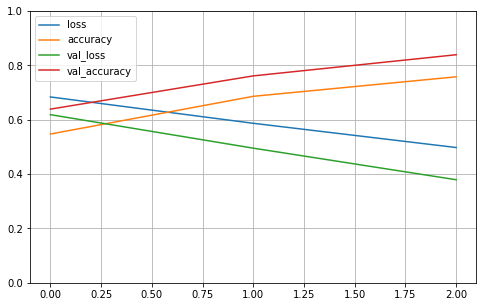

Train set ones/size 4895 / 9632
Compute valiation accuracy
Valid sizes (8223, 4997) (8223,)
Valid set ones/size 4146 / 8223
Range of scores: 0.0053534377 to 0.99813145
Score threshold 0.5
Prediction set ones/size 4513 / 8223


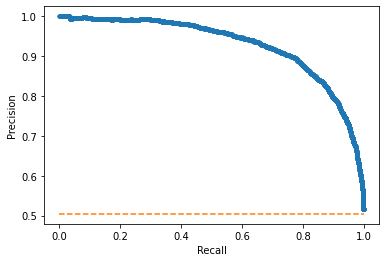

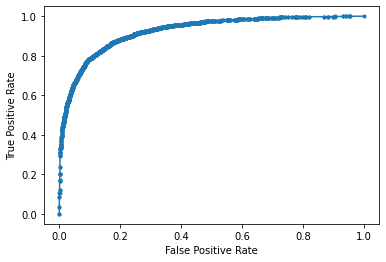

Accuracy: 83.91% Precision: 81.28% Recall: 88.47%
F1: 84.72% AUPRC: 92.83% AUROC: 92.41%
2023-02-06 13:23:59.438937
Fold 5
Model params (mean -1.32, wgt 0.53) (mean -0.17, wgt 0.47)
RCI threshold derived from training set: [-0.77548884]
FIT
2023-02-06 13:24:06.597627
PREDICT
2023-02-06 13:24:28.111188


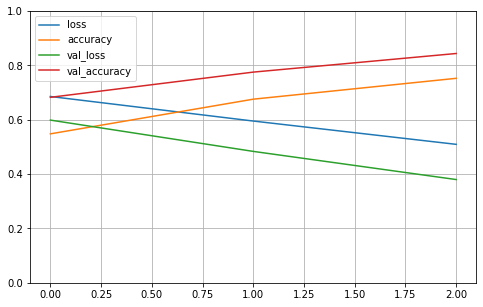

Train set ones/size 4868 / 9602
Compute valiation accuracy
Valid sizes (8224, 4997) (8224,)
Valid set ones/size 4212 / 8224
Range of scores: 0.0034131147 to 0.9990336
Score threshold 0.5
Prediction set ones/size 3942 / 8224


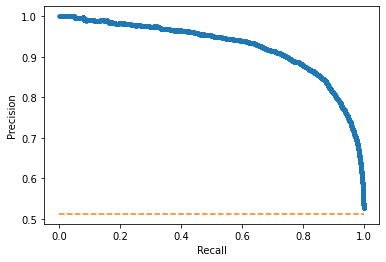

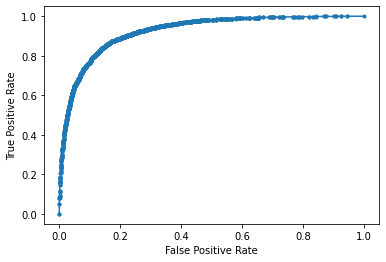

Accuracy: 84.36% Precision: 87.11% Recall: 81.53%
F1: 84.23% AUPRC: 92.45% AUROC: 92.45%
2023-02-06 13:24:29.748164

Completed cross validation 5 folds 3 epochs
 accuracy mean 84.26% +/- 0.54
 precision mean 84.63% +/- 2.82
 recall mean 84.66% +/- 3.54
 F1 mean 84.53% +/- 0.70
 AUPRC mean 92.89% +/- 0.60
 AUROC mean 92.58% +/- 0.58
Finished cell Line 12 GM12878

2023-02-06 13:24:31.170915
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-06 13:24:42.055979
splitting
Fold 1
Model params (mean -1.87, wgt 0.37) (mean 0.01, wgt 0.63)
RCI threshold derived from training set: [-0.67529738]
FIT
2023-02-06 13:24:45.871585
PREDICT
2023-02-06 13:24:55.949875


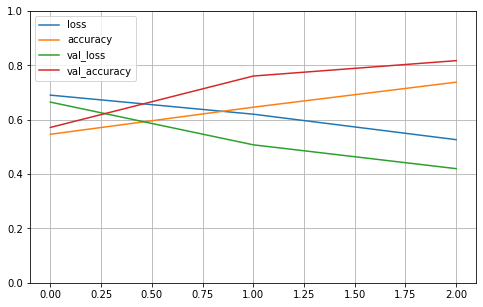

Train set ones/size 3493 / 6171
Compute valiation accuracy
Valid sizes (5387, 4997) (5387,)
Valid set ones/size 3078 / 5387
Range of scores: 0.0024807823 to 0.9975715
Score threshold 0.5
Prediction set ones/size 2694 / 5387


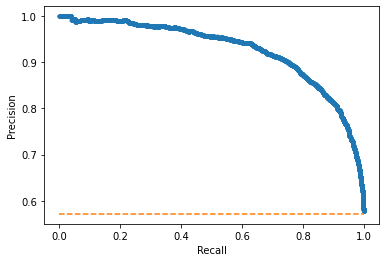

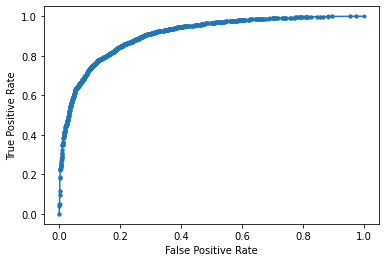

Accuracy: 81.73% Precision: 88.86% Recall: 77.78%
F1: 82.95% AUPRC: 92.74% AUROC: 90.68%
2023-02-06 13:24:57.158934
Fold 2
Model params (mean -1.88, wgt 0.36) (mean 0.02, wgt 0.64)
RCI threshold derived from training set: [-0.67189528]
FIT
2023-02-06 13:25:03.712771
PREDICT
2023-02-06 13:25:12.267527


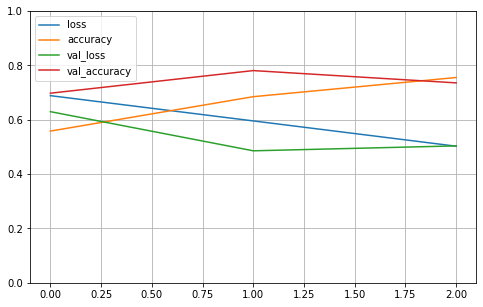

Train set ones/size 3471 / 6176
Compute valiation accuracy
Valid sizes (5419, 4997) (5419,)
Valid set ones/size 3101 / 5419
Range of scores: 0.013376006 to 0.99950516
Score threshold 0.5
Prediction set ones/size 4410 / 5419


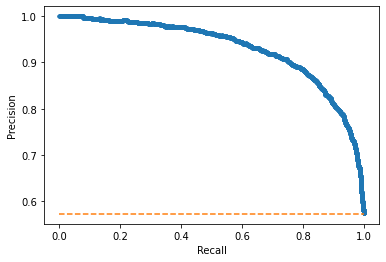

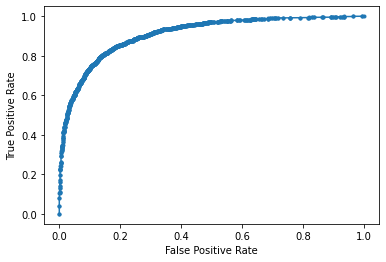

Accuracy: 73.56% Precision: 68.91% Recall: 98.00%
F1: 80.92% AUPRC: 93.08% AUROC: 90.94%
2023-02-06 13:25:13.714171
Fold 3
Model params (mean 0.01, wgt 0.64) (mean -1.87, wgt 0.36)
RCI threshold derived from training set: [-0.67272588]
FIT
2023-02-06 13:25:18.925879
PREDICT
2023-02-06 13:25:29.849379


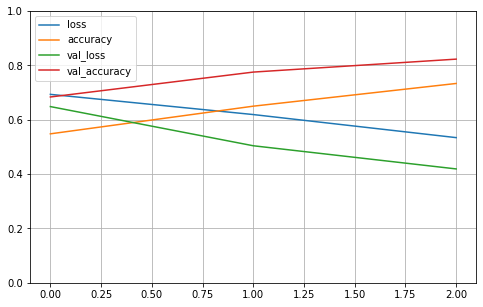

Train set ones/size 3476 / 6200
Compute valiation accuracy
Valid sizes (5393, 4997) (5393,)
Valid set ones/size 3110 / 5393
Range of scores: 0.009394626 to 0.9949646
Score threshold 0.5
Prediction set ones/size 3541 / 5393


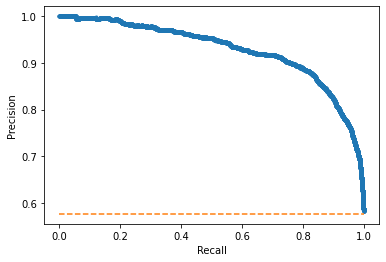

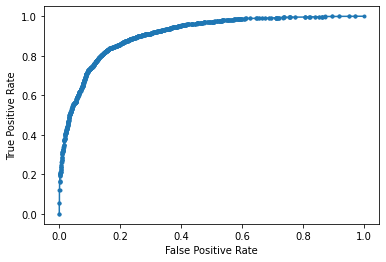

Accuracy: 82.29% Precision: 80.43% Recall: 91.58%
F1: 85.64% AUPRC: 92.82% AUROC: 90.90%
2023-02-06 13:25:31.070058
Fold 4
Model params (mean -1.88, wgt 0.36) (mean 0.02, wgt 0.64)
RCI threshold derived from training set: [-0.67294345]
FIT
2023-02-06 13:25:35.663113
PREDICT
2023-02-06 13:25:46.566662


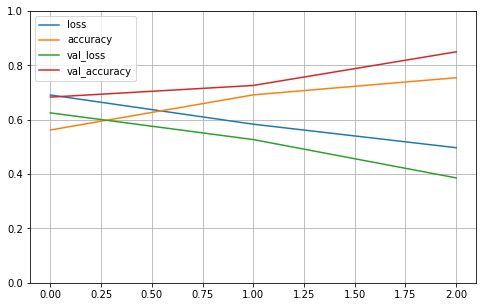

Train set ones/size 3473 / 6196
Compute valiation accuracy
Valid sizes (5381, 4997) (5381,)
Valid set ones/size 3087 / 5381
Range of scores: 0.004630063 to 0.9963013
Score threshold 0.5
Prediction set ones/size 3065 / 5381


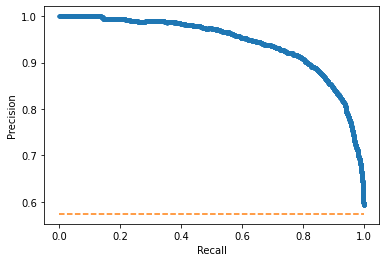

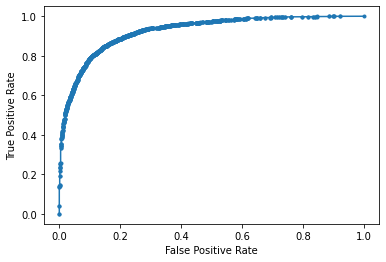

Accuracy: 84.98% Precision: 87.18% Recall: 86.56%
F1: 86.87% AUPRC: 94.33% AUROC: 92.53%
2023-02-06 13:25:48.435697
Fold 5
Model params (mean 0.02, wgt 0.64) (mean -1.88, wgt 0.36)
RCI threshold derived from training set: [-0.67351382]
FIT
2023-02-06 13:25:54.487185
PREDICT
2023-02-06 13:26:05.635401


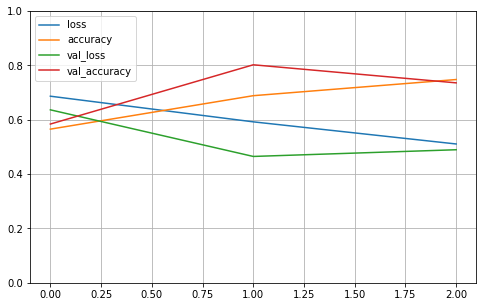

Train set ones/size 3502 / 6191
Compute valiation accuracy
Valid sizes (5371, 4997) (5371,)
Valid set ones/size 3096 / 5371
Range of scores: 0.0018590566 to 0.9940871
Score threshold 0.5
Prediction set ones/size 1840 / 5371


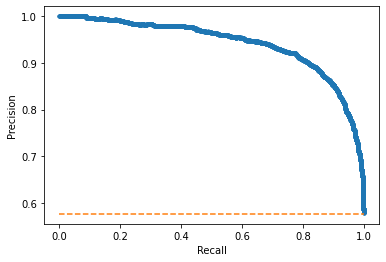

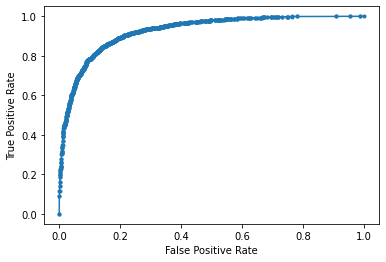

Accuracy: 73.56% Precision: 95.54% Recall: 56.78%
F1: 71.23% AUPRC: 94.17% AUROC: 92.56%
2023-02-06 13:26:07.725915

Completed cross validation 5 folds 3 epochs
 accuracy mean 79.23% +/- 4.76
 precision mean 84.19% +/- 9.02
 recall mean 82.14% +/- 14.30
 F1 mean 81.52% +/- 5.55
 AUPRC mean 93.43% +/- 0.68
 AUROC mean 91.52% +/- 0.84
Finished cell Line 13 K562

2023-02-06 13:26:09.169916
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-06 13:26:12.704643
splitting
Fold 1
Model params (mean -2.71, wgt 0.31) (mean 0.03, wgt 0.69)
RCI threshold derived from training set: [-0.80899587]
FIT
2023-02-06 13:26:14.099203
PREDICT
2023-02-06 13:26:17.948655


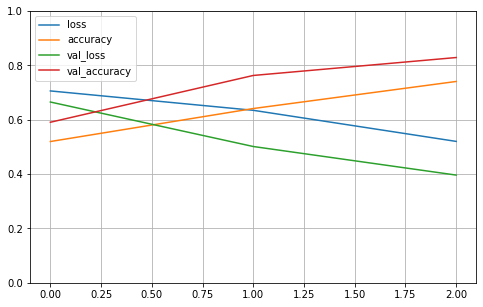

Train set ones/size 1185 / 2430
Compute valiation accuracy
Valid sizes (2062, 4997) (2062,)
Valid set ones/size 963 / 2062
Range of scores: 0.0040484867 to 0.9934309
Score threshold 0.5
Prediction set ones/size 1006 / 2062


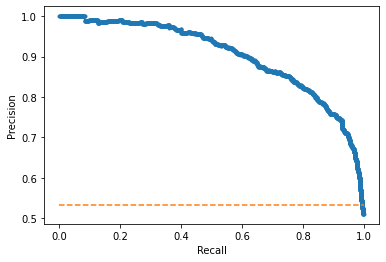

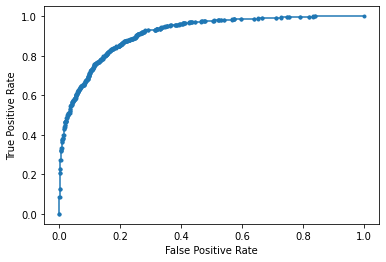

Accuracy: 82.88% Precision: 80.32% Recall: 83.90%
F1: 82.07% AUPRC: 90.28% AUROC: 91.29%
2023-02-06 13:26:18.881577
Fold 2
Model params (mean -2.71, wgt 0.31) (mean 0.04, wgt 0.69)
RCI threshold derived from training set: [-0.80553108]
FIT
2023-02-06 13:26:22.640513
PREDICT
2023-02-06 13:26:27.214520


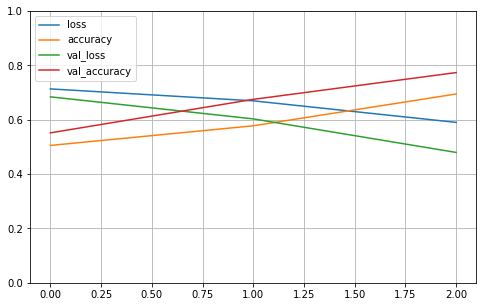

Train set ones/size 1188 / 2434
Compute valiation accuracy
Valid sizes (2101, 4997) (2101,)
Valid set ones/size 995 / 2101
Range of scores: 0.006284983 to 0.93586177
Score threshold 0.5
Prediction set ones/size 909 / 2101


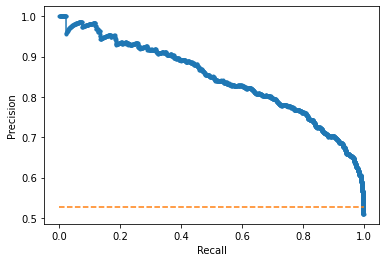

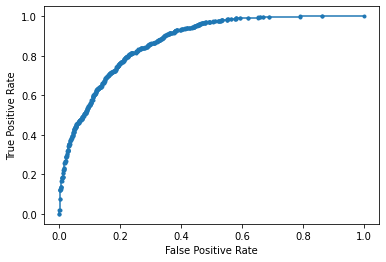

Accuracy: 77.34% Precision: 78.55% Recall: 71.76%
F1: 75.00% AUPRC: 84.50% AUROC: 87.05%
2023-02-06 13:26:28.034648
Fold 3
Model params (mean 0.03, wgt 0.69) (mean -2.71, wgt 0.31)
RCI threshold derived from training set: [-0.81395013]
FIT
2023-02-06 13:26:30.497691
PREDICT
2023-02-06 13:26:36.221172


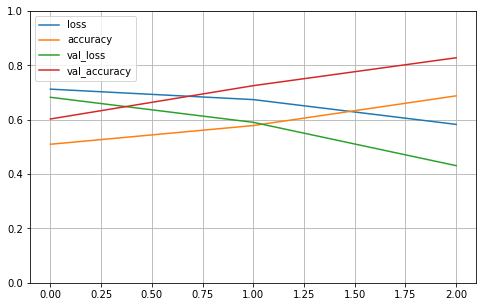

Train set ones/size 1177 / 2425
Compute valiation accuracy
Valid sizes (2104, 4997) (2104,)
Valid set ones/size 991 / 2104
Range of scores: 0.0038964474 to 0.96922284
Score threshold 0.5
Prediction set ones/size 1019 / 2104


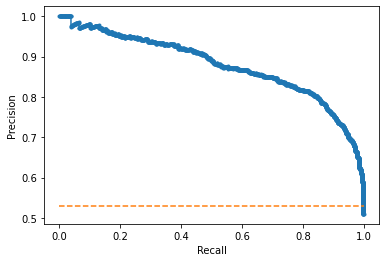

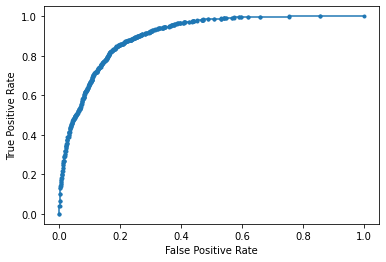

Accuracy: 82.79% Precision: 80.86% Recall: 83.15%
F1: 81.99% AUPRC: 87.85% AUROC: 90.29%
2023-02-06 13:26:37.117185
Fold 4
Model params (mean 0.05, wgt 0.69) (mean -2.70, wgt 0.31)
RCI threshold derived from training set: [-0.80197824]
FIT
2023-02-06 13:26:39.643131
PREDICT
2023-02-06 13:26:45.355173


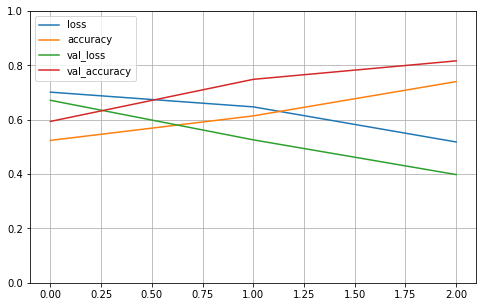

Train set ones/size 1192 / 2441
Compute valiation accuracy
Valid sizes (2060, 4997) (2060,)
Valid set ones/size 969 / 2060
Range of scores: 0.00022301986 to 0.99078065
Score threshold 0.5
Prediction set ones/size 1107 / 2060


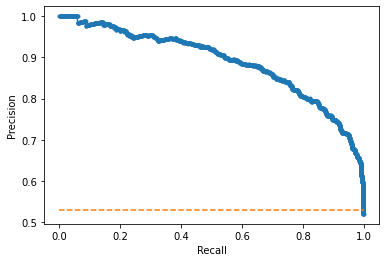

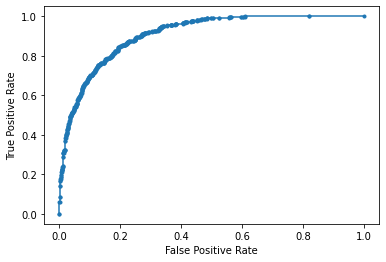

Accuracy: 81.65% Precision: 76.69% Recall: 87.62%
F1: 81.79% AUPRC: 88.89% AUROC: 90.78%
2023-02-06 13:26:46.733001
Fold 5
Model params (mean 0.03, wgt 0.70) (mean -2.71, wgt 0.30)
RCI threshold derived from training set: [-0.80420076]
FIT
2023-02-06 13:26:49.303995
PREDICT
2023-02-06 13:26:53.086264


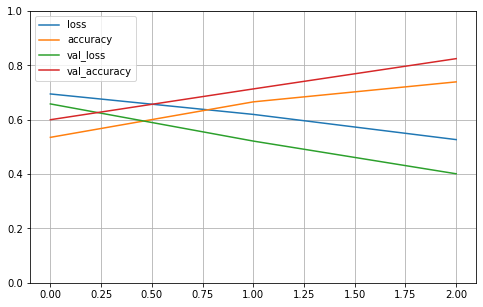

Train set ones/size 1179 / 2420
Compute valiation accuracy
Valid sizes (2065, 4997) (2065,)
Valid set ones/size 980 / 2065
Range of scores: 0.0015102501 to 0.9975586
Score threshold 0.5
Prediction set ones/size 1180 / 2065


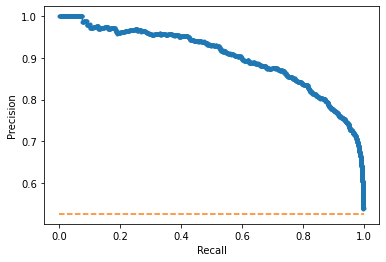

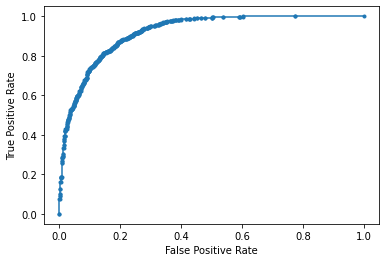

Accuracy: 82.47% Precision: 76.19% Recall: 91.73%
F1: 83.24% AUPRC: 90.21% AUROC: 91.96%
2023-02-06 13:26:53.941269

Completed cross validation 5 folds 3 epochs
 accuracy mean 81.43% +/- 2.09
 precision mean 78.52% +/- 1.87
 recall mean 83.63% +/- 6.68
 F1 mean 80.82% +/- 2.95
 AUPRC mean 88.35% +/- 2.12
 AUROC mean 90.27% +/- 1.71
Finished cell Line 14 IMR.90

2023-02-06 13:26:55.178735


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())